# Text Mining Project
### 1 Dataset
Scaricare i bugiardini (foglietti illustrativi) di cinque prodotti farmaceutici a
scelta.
### 2 Obiettivo
L'obiettivo è analizzare il sentiment dei bugiardini analizzando separatamente le sezioni che li compongono.

In [1]:
import re
import pandas as pd
import numpy as np
import pdfplumber
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
import spacy
import sentita_1.sentita 
from sklearn.feature_extraction.text import TfidfVectorizer
from cleantext import clean
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from nltk import bigrams, trigrams
# Assicurarsi che le risorse NLTK necessarie siano scaricate
nltk.download('punkt')
# pip install vader-multi
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
spacy.load('it_core_news_sm')
from sentita_1.sentita import calculate_polarity
from feel_it import EmotionClassifier


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Estrazione dati  


In [2]:
# Frasi chiave per identificare la stringa da escludere
frasi_chiave_esclusione = [
    "Documento reso disponibile da AIFA",
    "Esula dalla competenza dell’AIFA"
]

In [3]:
# Funzione per verificare se una linea contiene parti della stringa da escludere
def linea_da_escludere(line):
    return any(frase in line for frase in frasi_chiave_esclusione)

# Funzione per verificare se una linea è un numero di pagina
def is_page_number(line):
    return line.strip().isdigit()

In [4]:
# Estrae i paragrafi specifici da un bugiardino in formato PDF e crea un DataFrame.

def estrai_paragrafi_bugiardino(pdf_file, paragrafi_titoli, escludi_linee=linea_da_escludere, rileva_numero_pagina=is_page_number):
    """
    Args:
        pdf_file (str): Il nome del file PDF del bugiardino.
        paragrafi_titoli (list): Una lista di stringhe che identificano i titoli dei paragrafi da estrarre.
        escludi_linee (function): Una funzione che accetta una linea e restituisce True se la linea deve essere esclusa.
        rileva_numero_pagina (function): Una funzione che accetta una linea e restituisce True se la linea è un numero di pagina.

    Returns:
        pd.DataFrame: Un DataFrame con due colonne: 'Paragrafo' e 'Contenuto'.
    """
    # Apri il file PDF
    with pdfplumber.open(pdf_file) as pdf:
        # Inizializza le righe della tabella
        rows = []

        # Inizializza il paragrafo corrente e il contenuto
        current_paragraph = ''
        current_content = ''
        in_paragraph = False

        # Itera attraverso le pagine
        for page in pdf.pages:
            # Estrai il testo dalla pagina
            text = page.extract_text()

            # Dividi il testo in righe
            lines = text.split('\n')

            # Itera attraverso le righe
            for line in lines:
                # Se la linea contiene parti della stringa da escludere, interrompi la lettura delle righe
                if escludi_linee(line):
                    break

                # Ignora i numeri di pagina
                if rileva_numero_pagina(line):
                    continue

                # Verifica se la linea è l'inizio di un nuovo paragrafo
                if any(title in line for title in paragrafi_titoli):
                    # Se c'è un paragrafo corrente e un contenuto, aggiungilo alle righe
                    if current_paragraph and current_content:
                        rows.append([current_paragraph, current_content.strip()])
                        current_paragraph = ''
                        current_content = ''

                    # Imposta il paragrafo corrente al nuovo paragrafo
                    current_paragraph = line.strip()
                    in_paragraph = True  # Attiva la modalità di raccolta contenuto
                elif in_paragraph:
                    # Aggiungi la linea al contenuto corrente se non è vuota
                    if line.strip():
                        current_content += ' ' + line.strip()

        # Aggiungi l'ultimo paragrafo e contenuto alle righe
        if current_paragraph and current_content:
            rows.append([current_paragraph, current_content.strip()])

    # Crea un DataFrame pandas dalle righe
    df = pd.DataFrame(rows, columns=['Paragrafo', 'Contenuto'])

    return df


In [5]:
# Funzione che costriusce la lista dei possibili titoli dei paragrafi dei bugiardini
def titoli_paragrafi (nome_farmaco):  
  paragrafi_titoli = [
    f"1. Che cos’è {nome_farmaco} e a cosa serve",
    f"2. Cosa deve sapere prima di usare {nome_farmaco}",
    f"3. Come usare {nome_farmaco}",  
    "4. Possibili effetti indesiderati",
    f"5. Come conservare {nome_farmaco}", 
    "6. Contenuto della confezione e altre informazioni",
    f"1 Che cos’è {nome_farmaco} e a cosa serve",
    f"2 Cosa deve sapere prima di prendere {nome_farmaco}",
    f"3 Come prendere {nome_farmaco}",  
    "4 Possibili effetti indesiderati",
    f"5 Come conservare {nome_farmaco}", 
    "6 Contenuto della confezione e altre informazioni",
    f"2. Cosa deve sapere prima di prendere {nome_farmaco}",
    f"3. Come prendere {nome_farmaco}" , 
    f"1. Cos’è {nome_farmaco} e a cosa serve"
  ]

  return(paragrafi_titoli)

# Funzioni di pre-processing

In [6]:
# Caricamento delle stopwords dal file stopwords.txt
with open('stopwords-it.txt', 'r', encoding='utf-8') as file:
    stop_words = set(file.read().split())

# Funzione per rimuovere la punteggiatura e sostituirla con spazi
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

# Funzione per pulire il testo e rimuovere le stopwords
def clean_and_remove_stopwords(text):
    # Rimuove la punteggiatura sostituendola con spazi
    text = remove_punctuation(text)
    
    # Ulteriori pulizie del testo
    cleaned_text = clean(text,
                         fix_unicode=True,  # rimuove i caratteri unicode
                         to_ascii=True,     # converte i caratteri non-ASCII a ASCII
                         lower=True,        # converte tutto in minuscolo
                         no_line_breaks=True,  # rimuove i ritorni a capo
                         no_urls=True,      # rimuove URL
                         no_emails=True,    # rimuove email
                         no_phone_numbers=True,  # rimuove numeri di telefono
                         no_numbers= True,  # mantiene i numeri
                         no_digits=False,   # mantiene le cifre
                         no_currency_symbols=True  # rimuove simboli di valuta
                         # no_punct=False   # Disabilitato per evitare la rimozione totale della punteggiatura
                        )
    
    # Rimozione delle stopwords
    return ' '.join([word for word in cleaned_text.split() if word not in stop_words])




In [7]:
# Pulizia del contenuto eliminando stopwords, segni di punteggiatura, numeri. Esegue la tokenizzazione sulla colonna 'contenuto' e fornisce il grafico delle frequenze dei primi 20 token
def clean_stop_tok_graph(df, azienda):
  
  #Divisione della colonna "Paragrafo" in "Numero" e "Sezione"
  #df[['Numero', 'Sezione']] =df['Paragrafo'].str.split('. ', 1, expand=True)

  # Utilizzo della regex per dividere 'Paragrafo' in 'Numero' e 'Sezione'
  df[['Numero', 'Sezione']] = df['Paragrafo'].str.extract(r'^(\d+)\. (.*)')
  
  # Elimino colonna "Paragrafo"
  df.drop(columns=['Paragrafo'], inplace=True)

  # Riordino delle colonne
  df =df[['Numero', 'Sezione', 'Contenuto']]
  
  # trasformo tutto il testo in minuscolo
  df['Sezione'] =df['Sezione'].str.lower()
  df['Contenuto'] =df['Contenuto'].str.lower() 
 

  # Applicazione della funzione alla colonna 'Contenuto'
  df['Contenuto'] =df['Contenuto'].apply(clean_and_remove_stopwords)

  # Sostituisco azienda (ad esempio 'salf') e '<url>' con carattere vuoto ''. Perchè l'azienda che profuce questo farmaco ed è inutile ai fini dello studio
  df['Contenuto'] = df['Contenuto'].str.replace( azienda, '')
  df['Contenuto'] = df['Contenuto'].str.replace('<url>', '')
  df['Contenuto'] = df['Contenuto'].str.replace('<number>', '')
  
  # Esegue la tokenizzazione sui contenuti dei paragrafi
  df['Tokenized_Content'] = df['Contenuto'].apply(lambda x: word_tokenize(x.lower()))

  # Creazione del DataFrame 'tokenized' con le colonne desiderate
  df_token = df[['Numero', 'Sezione', 'Contenuto', 'Tokenized_Content']].copy()

  # Elimino colonna "Paragrafo"
  df.drop(columns=['Tokenized_Content'], inplace=True)

  # Calcolo della frequenza delle parole
  all_words = [word for tokens in df_token['Tokenized_Content'] for word in tokens]
  freq_dist = FreqDist(all_words)

  # Estrazione delle parole più comuni e delle loro frequenze
  common_words = freq_dist.most_common(20)
  words, frequencies = zip(*common_words)

  # Creazione dell'istogramma delle frequenze delle parole più comuni
  plt.figure(figsize=(10, 6))
  plt.bar(words, frequencies, color='skyblue')
  plt.xlabel('Parole')
  plt.ylabel('Frequenza')
  plt.title('Istogramma delle 20 parole più frequenti')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

  #Wordcloud
  # Concateniamo tutte le parole nella colonna Tokenized_Content in un'unica stringa
  text = ' '.join([' '.join(tokens) for tokens in df_token['Tokenized_Content']])

  # Crea la wordcloud
  wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

  # Visualizza la wordcloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')  # Nascondi gli assi
  plt.show()
  
  #TF-IDF (Term Frequency-Inverse Document Frequency). Tecnica che permette di identificare le parole più rilevanti del bugiardino, non solo le più frequenti.

  # Concateniamo tutte le parole nella colonna Tokenized_Content in una stringa di documenti
  documents = [' '.join(tokens) for tokens in df_token['Tokenized_Content']]

  # Calcolo del TF-IDF
  vectorizer = TfidfVectorizer(max_features=20)  # Limitiamo alle 20 parole più influenti
  X = vectorizer.fit_transform(documents)
  tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

  # Calcoliamo i punteggi medi TF-IDF per ogni parola e ordiniamo in modo decrescente
  mean_tfidf = tfidf_df.mean().sort_values(ascending=False)

  # Visualizziamo i risultati con colori personalizzati e etichette orizzontali
  plt.figure(figsize=(10, 6))
  mean_tfidf.plot(kind='barh', color=['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'lightblue', 
                                    'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightyellow', 
                                    'lightsteelblue', 'lightslategray', 'lightpink', 'lightslategrey', 
                                    'lightgoldenrodyellow', 'lightcyan', 'lightcoral', 'lightgreen', 
                                    'lightgray', 'lightseagreen', 'lightblue'])
  plt.title('Top 20 Parole più Rilevanti (TF-IDF)')
  plt.xlabel('Punteggio TF-IDF Medio')
  plt.ylabel('Parole')
  plt.gca().invert_yaxis()  # Inverti l'asse y per avere il punteggio TF-IDF più alto in cima
  plt.tight_layout()  # Ottimizza il layout per evitare sovrapposizioni
  plt.show()
  plt.show()


  # Unire tutti i token in una singola lista di token
  all_tokens = [token for sublist in df_token['Tokenized_Content'] for token in sublist]

  #bigrammi

  # Estrazione dei bigrammi
  all_bigrams = list(bigrams(all_tokens))
  # Conteggio dei bigrammi
  bigram_counts = Counter(all_bigrams)
  # Stampare i 10 bigrammi più comuni
  print(bigram_counts.most_common(10))

  # Ottenere i 10 bigrammi più comuni
  common_bigrams = bigram_counts.most_common(10)

  # Separare i bigrammi e le loro frequenze
  bigrammi, counts = zip(*common_bigrams)
  bigrammi = [' '.join(bigram) for bigram in bigrammi]  # Unire le parole dei bigrammi per la visualizzazione

  # Creare il grafico
  plt.figure(figsize=(10, 6))
  plt.barh(bigrammi, counts, color='lightcoral')
  plt.xlabel('Frequenze')
  plt.ylabel('Bigrammi')
  plt.title('Frequenze dei 10 Bigrammi più Comuni')
  plt.gca().invert_yaxis()  # Invertire l'asse y per avere il bigramma più frequente in cima
  plt.tight_layout()
  plt.show()

#Trigrammi 

  # Estrazione dei trigrammi
  all_trigrams = list(trigrams(all_tokens))

  # Conteggio dei trigrammi
  trigram_counts = Counter(all_trigrams)

  # Ottenere i 10 trigrammi più comuni
  common_trigrams = trigram_counts.most_common(10)

  # Separare i trigrammi e le loro frequenze
  trigrammi, counts = zip(*common_trigrams)
  trigrammi = [' '.join(trigram) for trigram in trigrammi]  # Unire le parole dei trigrammi per la visualizzazione

  # Creare il grafico
  plt.figure(figsize=(10, 6))
  plt.barh(trigrammi, counts, color='lightblue')
  plt.xlabel('Frequenze')
  plt.ylabel('Trigrammi')
  plt.title('Frequenze dei 10 Trigrammi più Comuni')
  plt.gca().invert_yaxis()  # Invertire l'asse y per avere il trigramma più frequente in cima
  plt.tight_layout()
  plt.show()
 


 
  return df


# Funzioni di sentiment e emotions analysis

### Vader

In [8]:
def vader(df):
  
  analyzer = SentimentIntensityAnalyzer()

  # Creazione di un dizionario vuoto per memorizzare i risultati delle analisi di sentiment
  res_vader = {}

  # Iterazione attraverso ogni riga del DataFrame df utilizzando tqdm per visualizzare una barra di avanzamento
  # e ottenere l'indice della riga (i) e i valori della riga (row)
  for i, row in df.iterrows():
      # Ottenimento del testo della recensione dalla colonna 'review'
      text = row['Contenuto']
      # Ottenimento dell'ID dalla colonna 'Id'
      myid = row['Numero']
      # Calcolo del sentiment polarity score per il testo della recensione utilizzando l'oggetto sia
      # e memorizzazione del risultato nel dizionario res con l'ID come chiave
      res_vader[myid] = analyzer.polarity_scores(text)
  
  # Creazione di un DataFrame 'vaders' dai risultati dell'analisi di sentiment, trasponendoli e impostando l'ID come indice
  vaders = pd.DataFrame(res_vader).T

  # Reset dell'indice del DataFrame 'vaders' e rinominazione della colonna 'index' in 'Id'
  vaders = vaders.reset_index().rename(columns={'index': 'Numero'})

  # Unione del DataFrame 'vaders' con il DataFrame 'df' utilizzando una fusione sinistra (left join)
  vaders = vaders.merge(df, how='left')

  ax = sns.barplot(data = vaders, x = 'Numero', y = 'compound')
  ax.set_title('Compound score paragraph ') 
  plt.show()

  # Creazione di una figura con 3 subplot, dimensioni (12, 3)
  fig, axs = plt.subplots(1, 3, figsize=(12, 3))

  # Barplot per la colonna 'pos' in base al 'Numero', con il primo subplot axs[0]
  sns.barplot(data=vaders, x='Numero', y='pos', ax=axs[0])

  # Barplot per la colonna 'neu' in base al 'Numero', con il secondo subplot axs[1]
  sns.barplot(data=vaders, x='Numero', y='neu', ax=axs[1])

  # Barplot per la colonna 'neg' in base al 'Numero', con il terzo subplot axs[2]
  sns.barplot(data=vaders, x='Numero', y='neg', ax=axs[2])

  # Impostazione del titolo per il primo subplot
  axs[0].set_title('Positive')
  # Impostazione del titolo per il secondo subplot
  axs[1].set_title('Neutral')
  # Impostazione del titolo per il terzo subplot
  axs[2].set_title('Negative')

  # Aggiustamento dello spaziamento tra i subplot
  plt.tight_layout()

  #plt.savefig('posneuneg.png')

  # Visualizzazione della figura
  plt.show()

  return vaders

### umBERTo

In [9]:
def umBERTo(df):  
  # Definizione del modello pre-addestrato utilizzato, in questo caso "Musixmatch/umberto-commoncrawl-cased-v1"
  MODEL = f"Musixmatch/umberto-commoncrawl-cased-v1"

  # Creazione del tokenizer utilizzando il modello pre-addestrato
  tokenizer = AutoTokenizer.from_pretrained(MODEL)

  # Creazione del modello per la classificazione di sequenze utilizzando il modello pre-addestrato
  model_umberto = AutoModelForSequenceClassification.from_pretrained(MODEL)


  # Creazione di un dizionario vuoto per memorizzare i risultati delle analisi di sentiment
  res_umb = {}

  # Iterazione attraverso ogni riga del DataFrame df utilizzando tqdm per visualizzare una barra di avanzamento
  # e ottenere l'indice della riga (i) e i valori della riga (row)
  for i, row in df.iterrows():
      # Ottenimento del testo della recensione dalla colonna 'review'
      text = row['Contenuto']
      # prende solo le prime 255 parole, questo perchè umBERTo ha un limite massimo di 514 tokens
      words = text.split()  # Divide il testo in una lista di parole
      first_255_words = words[:255]  # Prende le prime 255 parole
      first_255_words_text = ' '.join(first_255_words)  # Unisce le parole in una singola stringa

      # Ottenimento dell'ID dalla colonna 'Id'
      myid = row['Numero']
      # Calcolo del sentiment polarity score per il testo della recensione utilizzando l'oggetto sia
      # e memorizzazione del risultato nel dizionario res con l'ID come chiave
    
      encoded_input = tokenizer(first_255_words_text, return_tensors= 'pt')
      #input_ids = torch.tensor(encoded_input).unsqueeze(0)  # Batch size 1
      outputs = model_umberto(**encoded_input)

      # Estrazione dei punteggi di sentiment dall'output del modello e conversione in un array NumPy
      scores = outputs[0][0].detach().numpy()
      # Applicazione della funzione softmax ai punteggi per ottenere probabilità normalizzate
      scores = softmax(scores)
  
      # Creazione di un dizionario che associa i punteggi a etichette specifiche
      scores_dict = {
        'umberto_neg' : scores[0],
        'umberto_pos' : scores[1],
  
      }

      res_umb[myid] = scores_dict


  # Creazione di un DataFrame 'umberto' dai risultati dell'analisi di sentiment, trasponendoli e impostando l'ID come indice
  umberto = pd.DataFrame(res_umb).T

  # Reset dell'indice del DataFrame 'umberto' e rinominazione della colonna 'index' in 'Id'
  umberto = umberto.reset_index().rename(columns={'index': 'Numero'})

  # Unione del DataFrame 'umberto' con il DataFrame 'df' utilizzando una fusione sinistra (left join)
  umberto = umberto.merge(df, how='left')

  # Plot dei dati
  plt.figure(figsize=(10, 6))  # Imposta la dimensione della figura

  # Linea per umberto_neg
  plt.plot(umberto['Numero'], umberto['umberto_neg'], marker='o', linestyle='-', color='b', label='umberto_neg')

  # Linea per umberto_pos
  plt.plot(umberto['Numero'], umberto['umberto_pos'], marker='s', linestyle='-', color='r', label='umberto_pos')

  # Etichette degli assi e del titolo
  plt.xlabel('Numero')
  plt.ylabel('Valore')
  plt.title('Andamento del sentiment al variare del numero di sezione')

  # Legenda
  plt.legend()

  # Mostra il grafico
  plt.grid(True)  # Abilita la griglia
  plt.tight_layout()  # Ottimizza il layout
  plt.show()

  return umberto  
 

### SentITA

In [10]:
def senITA(df): 

  # Creazione di un dizionario vuoto per memorizzare i risultati delle analisi di sentiment
  res_sent = {}

  # Iterazione attraverso ogni riga del DataFrame df utilizzando tqdm per visualizzare una barra di avanzamento
  # e ottenere l'indice della riga (i) e i valori della riga (row)
  for i, row in df.iterrows():
      # Ottenimento del testo della recensione dalla colonna 'review'
      text = row['Contenuto']
      # Ottenimento dell'ID dalla colonna 'Id'
      myid = row['Numero']
    
      #trasformazione in lista di stringhe
      text_list = [text]

      results, polarities = calculate_polarity(text_list)

      # Estrazione dei punteggi di sentiment dall'output del modello e conversione in un array NumPy
      scores = polarities[0]
      # Applicazione della funzione softmax ai punteggi per ottenere probabilità normalizzate
      scores = softmax(scores)

      # Creazione di un dizionario che associa i punteggi a etichette specifiche
      scores_dict = {
        'sentita_neg' : scores[0],
        'sentita_pos' : scores[1],
      }

      # Calcolo del sentiment polarity score per il testo del bugiardino utilizzando l'oggetto sia
      # e memorizzazione del risultato nel dizionario res con l'ID come chiave
      res_sent[myid] = scores_dict

  # Creazione di un DataFrame 'vaders' dai risultati dell'analisi di sentiment, trasponendoli e impostando l'ID come indice
  sentita = pd.DataFrame(res_sent).T

  # Reset dell'indice del DataFrame 'vaders' e rinominazione della colonna 'index' in 'Id'
  sentita = sentita.reset_index().rename(columns={'index': 'Numero'})

  # Unione del DataFrame 'vaders' con il DataFrame 'df' utilizzando una fusione sinistra (left join)
  sentita = sentita.merge(df, how='left')


  # Plot dei dati
  plt.figure(figsize=(10, 6))  # Imposta la dimensione della figura

  # Linea per umberto_neg
  plt.plot(sentita['Numero'], sentita['sentita_neg'], marker='o', linestyle='-', color='b', label='sentita_neg')

  # Linea per umberto_pos
  plt.plot(sentita['Numero'], sentita['sentita_pos'], marker='s', linestyle='-', color='r', label='sentita_pos')

  # Etichette degli assi e del titolo
  plt.xlabel('Numero')
  plt.ylabel('Valore')
  plt.title('Andamento del sentiment al variare del numero di sezione')

  # Legenda
  plt.legend()

  # Mostra il grafico
  plt.grid(True)  # Abilita la griglia
  plt.tight_layout()  # Ottimizza il layout
  plt.show()

  return sentita

### umBERTo vs sentITA

In [11]:
  # Aggiunta delle etichette di valore sopra le barre
def autolabel(rects , ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 punti di offset verso l'alto
                    textcoords="offset points",
                    ha='center', va='bottom')

In [12]:
def umBERTo_vs_sentITA(df_umberto, df_sentITA):
  # Grafico a linee per umberto_neg e sentita_neg
  plt.figure(figsize=(10, 6))
  plt.plot(df_umberto['Numero'], df_umberto['umberto_neg'], marker='o', linestyle='-', color='blue', label='umberto_neg')
  plt.plot(df_sentITA['Numero'], df_sentITA['sentita_neg'], marker='s', linestyle='--', color='cyan', label='sentita_neg')

  plt.xlabel('Numero')
  plt.ylabel('Valore Negativo')
  plt.title('Confronto umberto_neg vs sentita_neg')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Grafico a linee per umberto_pos e sentita_pos
  plt.figure(figsize=(10, 6))
  plt.plot(df_umberto['Numero'], df_umberto['umberto_pos'], marker='o', linestyle='-', color='red', label='umberto_pos')
  plt.plot(df_sentITA['Numero'], df_sentITA['sentita_pos'], marker='s', linestyle='--', color='orange', label='sentita_pos')

  plt.xlabel('Numero')
  plt.ylabel('Valore Positivo')
  plt.title('Confronto umberto_pos vs sentita_pos')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Se le barre arancioni sono più bilanciate rispetto a quelle verdi, potrebbe indicare che il modello ha una capacità migliore di distinguere tra sentimenti positivi e negativi.
  # Calcolo delle medie dei sentiment per ogni modello
  umberto_neg_mean = df_umberto['umberto_neg'].mean()
  umberto_pos_mean = df_umberto['umberto_pos'].mean()
  sentita_neg_mean = df_sentITA['sentita_neg'].mean()
  sentita_pos_mean = df_sentITA['sentita_pos'].mean()

  # Dati per il grafico
  labels = ['Negativo', 'Positivo']
  umberto_means = [umberto_neg_mean, umberto_pos_mean]
  sentita_means = [sentita_neg_mean, sentita_pos_mean]

  x = np.arange(len(labels))  # l'asse x
  width = 0.35  # larghezza delle barre

  fig, ax = plt.subplots(figsize=(10, 6))
  rects1 = ax.bar(x - width/2, umberto_means, width, label='UmBERTo', color='green')
  rects2 = ax.bar(x + width/2, sentita_means, width, label='SentITA', color='orange')

  # Aggiunta delle etichette, titolo e legenda
  ax.set_xlabel('Tipo di Sentiment')
  ax.set_ylabel('Valore Medio')
  ax.set_title('Confronto delle Medie dei Sentiment tra UmBERTo e SentITA')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

 
  autolabel(rects1 , ax)
  autolabel(rects2 , ax)

  plt.tight_layout()
  plt.show()


### FEEL-IT : Emotion  Classification for the Italian Language
Si è usata la seguente licenza : https://developer.x.com/en/developer-terms/commercial-terms

In [13]:
def Feel_it(df):
  
  emotion_classifier = EmotionClassifier()

  # Creazione di un dizionario vuoto per memorizzare i risultati delle analisi di sentiment
  res_feel = {}

  # Iterazione attraverso ogni riga del DataFrame df utilizzando tqdm per visualizzare una barra di avanzamento
  # e ottenere l'indice della riga (i) e i valori della riga (row)
  for i, row in df.iterrows():
      # Ottenimento del testo della recensione dalla colonna 'review'
      text = row['Contenuto']
      # Ottenimento dell'ID dalla colonna 'Id'
      myid = row['Numero']
    
      #trasformazione in lista di stringhe
      text_list = [text]
    
      res_feel_it =  emotion_classifier.predict(text_list)

      # Calcolo del emotions score per il testo della sezione del bugiardino e memorizzazione del risultato nel dizionario res con l'ID come chiave
      res_feel[myid] = res_feel_it

  # Creazione di un DataFrame 'feel-it' dai risultati dell'analisi di emotions, trasponendoli e impostando l'ID come indice
  feel_it = pd.DataFrame(res_feel).T
  feel_it.rename(columns={0: 'Emotion'}, inplace= True)

  # Reset dell'indice del DataFrame 'feel-it' e rinominazione della colonna 'index' in 'Id'
  feel_it = feel_it.reset_index().rename(columns={'index': 'Numero'})

  # Unione del DataFrame 'feel-it' con il DataFrame 'df' utilizzando una fusione sinistra (left join)
  feel_it = feel_it.merge(df, how='left')

  # Conteggio delle occorrenze di ciascuna emozione
  emotion_counts = feel_it['Emotion'].value_counts()

  # Definizione dei colori per ciascuna emozione
  colors = {
    'anger': 'red',
    'fear': 'purple',
    'joy': 'yellow',
    'sadness': 'blue'
  }

  # Emozioni complete
  emotions = ['anger', 'fear', 'joy', 'sadness']

  # Creazione del grafico a torta
  plt.figure(figsize=(8, 8))
  plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', colors=[colors[emotion] for emotion in emotion_counts.index])
  plt.title('Distribuzione delle emozioni nel dataset')

  # Aggiunta della legenda con tutte le emozioni possibili
  handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[emotion], markersize=10) for emotion in emotions]
  plt.legend(handles, emotions, title="Emozioni", loc="upper right", bbox_to_anchor=(1.1, 1))

  plt.tight_layout()
  plt.show()

  return feel_it

# Morfina

In [14]:
#Ricavo i possibili titoli dei paragrafi
paragrafi_titoli = titoli_paragrafi('MORFINA CLORIDRATO S.A.L.F.')

pdf_file= 'Morfina.pdf'
# Cambia l'estensione del file da 'nomefile.pdf' a 'nomefile.csv'
nome_csv= pdf_file.replace(".pdf", ".csv")

# Chiamare la funzione con il file PDF e i titoli dei paragrafi
df_morfina = estrai_paragrafi_bugiardino(pdf_file, paragrafi_titoli, linea_da_escludere, is_page_number)
print(df_morfina)

# Salvare il DataFrame in un file CSV
df_morfina.to_csv(nome_csv, index=False, encoding='utf-8')

                                           Paragrafo  \
0  1. Che cos’è MORFINA CLORIDRATO S.A.L.F. e a c...   
1  2. Cosa deve sapere prima di usare MORFINA CLO...   
2          3. Come usare MORFINA CLORIDRATO S.A.L.F.   
3                  4. Possibili effetti indesiderati   
4     5. Come conservare MORFINA CLORIDRATO S.A.L.F.   
5  6. Contenuto della confezione e altre informaz...   

                                           Contenuto  
0  MORFINA CLORIDRATO S.A.L.F. contiene il princi...  
1  Non usi MORFINA CLORIDRATO S.A.L.F. - se è all...  
2  Questo medicinale le sarà somministrato da un ...  
3  Come tutti i medicinali, questo medicinale può...  
4  Conservi questo medicinale fuori dalla portata...  
5  Cosa contiene MORFINA CLORIDRATO S.A.L.F. MORF...  


In [15]:
df_morfina

Paragrafo  \
0  1. Che cos’è MORFINA CLORIDRATO S.A.L.F. e a c...   
1  2. Cosa deve sapere prima di usare MORFINA CLO...   
2          3. Come usare MORFINA CLORIDRATO S.A.L.F.   
3                  4. Possibili effetti indesiderati   
4     5. Come conservare MORFINA CLORIDRATO S.A.L.F.   
5  6. Contenuto della confezione e altre informaz...   

                                           Contenuto  
0  MORFINA CLORIDRATO S.A.L.F. contiene il princi...  
1  Non usi MORFINA CLORIDRATO S.A.L.F. - se è all...  
2  Questo medicinale le sarà somministrato da un ...  
3  Come tutti i medicinali, questo medicinale può...  
4  Conservi questo medicinale fuori dalla portata...  
5  Cosa contiene MORFINA CLORIDRATO S.A.L.F. MORF...

## Pre-Processing

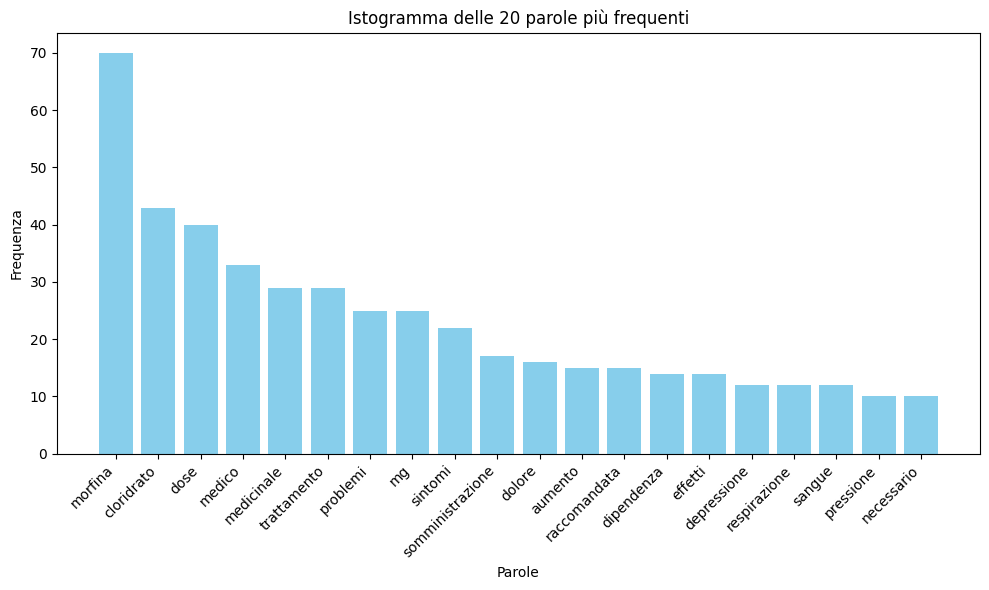

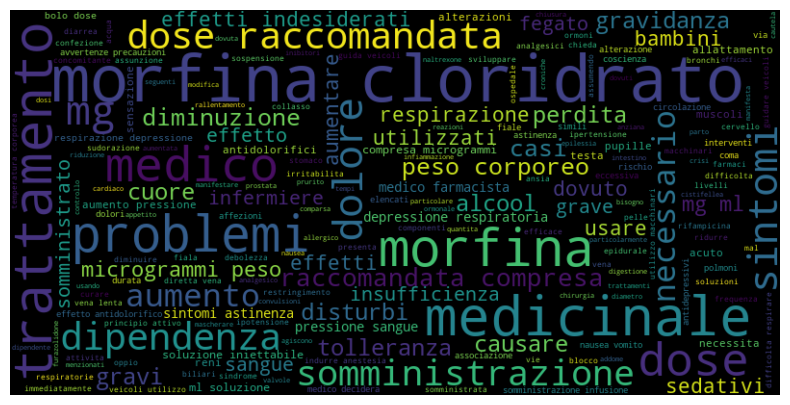

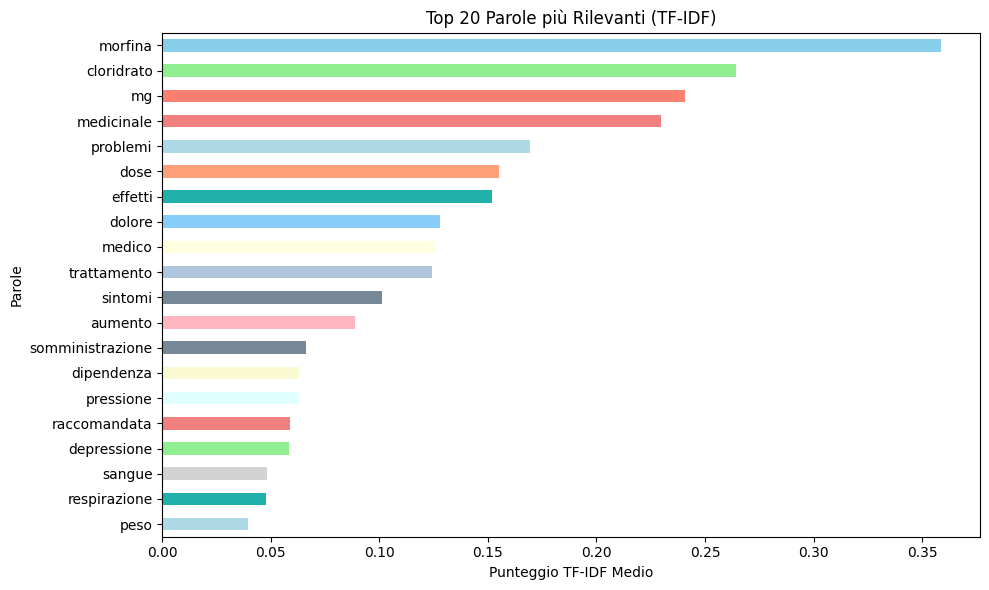

[(('morfina', 'cloridrato'), 43), (('dose', 'raccomandata'), 14), (('raccomandata', 'compresa'), 10), (('peso', 'corporeo'), 9), (('microgrammi', 'peso'), 8), (('mg', 'ml'), 8), (('effetti', 'indesiderati'), 7), (('depressione', 'respiratoria'), 6), (('medico', 'farmacista'), 6), (('pressione', 'sangue'), 6)]


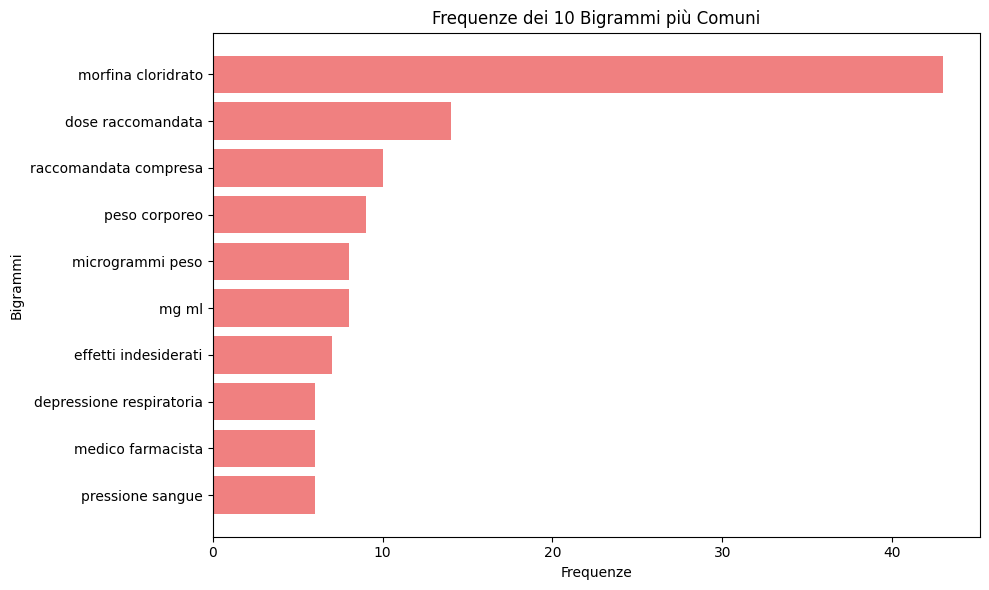

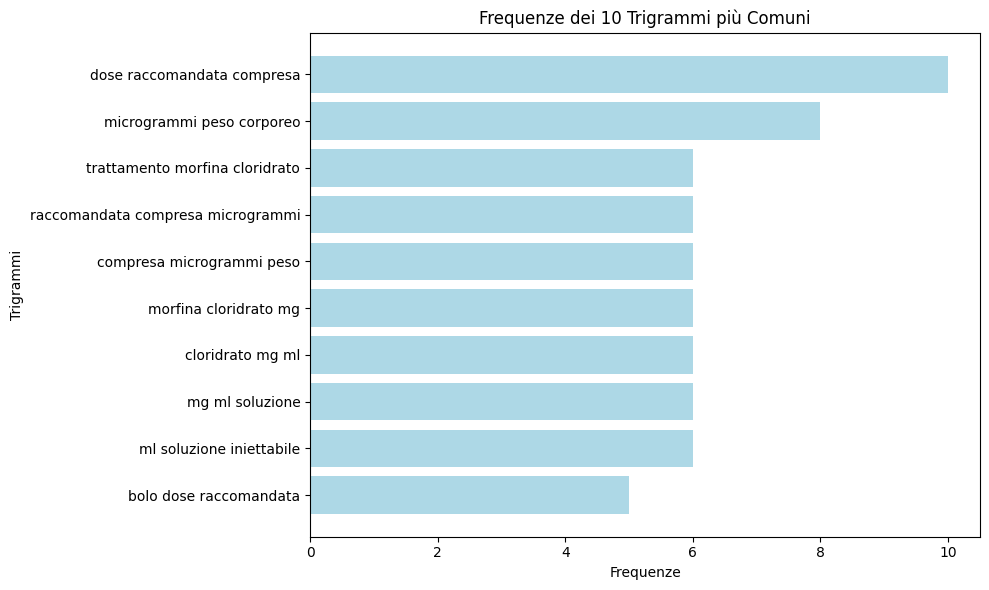

In [16]:
df_morfina= clean_stop_tok_graph(df_morfina, 'salf')


In [17]:
df_morfina

Numero                                            Sezione  \
0      1  che cos’è morfina cloridrato s.a.l.f. e a cosa...   
1      2  cosa deve sapere prima di usare morfina clorid...   
2      3             come usare morfina cloridrato s.a.l.f.   
3      4                     possibili effetti indesiderati   
4      5        come conservare morfina cloridrato s.a.l.f.   
5      6    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  morfina cloridrato principio attivo morfina cl...  
1  morfina cloridrato allergico morfina cloridrat...  
2  medicinale somministrato medico infermiere pel...  
3  medicinale causare effetti indesiderati sebben...  
4  conservi medicinale portata vista bambini medi...  
5  morfina cloridrato morfina cloridrato  mg ml s...

## Sentiment e Emotions Analysis

### Vader


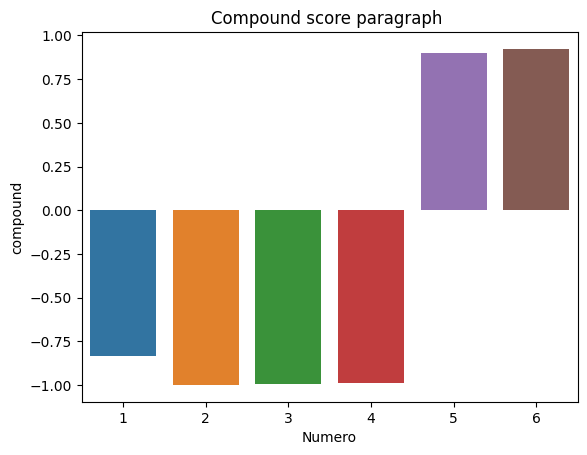

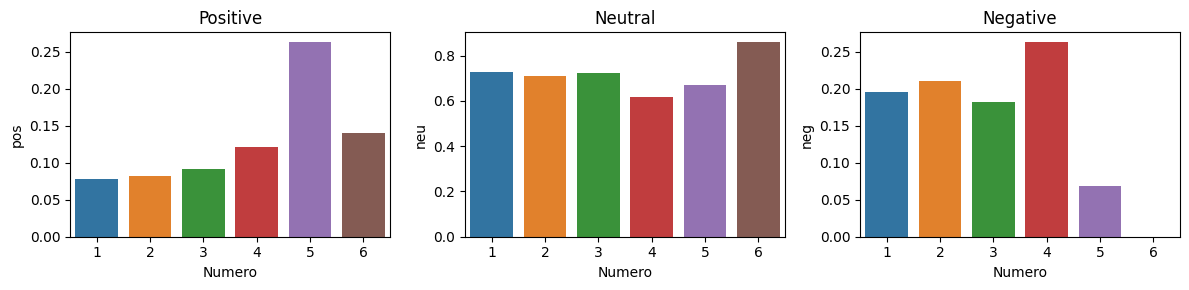

In [18]:
res_vaders_morf = vader(df_morfina)

In [19]:
res_vaders_morf

Numero    neg    neu    pos  compound  \
0      1  0.196  0.726  0.078   -0.8316   
1      2  0.210  0.708  0.082   -0.9994   
2      3  0.182  0.725  0.092   -0.9952   
3      4  0.263  0.617  0.121   -0.9894   
4      5  0.068  0.669  0.263    0.9001   
5      6  0.000  0.860  0.140    0.9231   

                                             Sezione  \
0  che cos’è morfina cloridrato s.a.l.f. e a cosa...   
1  cosa deve sapere prima di usare morfina clorid...   
2             come usare morfina cloridrato s.a.l.f.   
3                     possibili effetti indesiderati   
4        come conservare morfina cloridrato s.a.l.f.   
5    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  morfina cloridrato principio attivo morfina cl...  
1  morfina cloridrato allergico morfina cloridrat...  
2  medicinale somministrato medico infermiere pel...  
3  medicinale causare effetti indesiderati sebben...  
4  conservi medicinale portata vista bambini medi...  
5  morfina cloridrato morfina cloridrato  mg ml s...

### UmBERTo

In [ ]:
res_umBERTO_morf = umBERTo(df_morfina) 

In [ ]:
res_umBERTO_morf

Numero  umberto_neg  umberto_pos  \
0      1     0.509340     0.490660   
1      2     0.497172     0.502828   
2      3     0.502477     0.497523   
3      4     0.502425     0.497575   
4      5     0.504990     0.495010   
5      6     0.502433     0.497567   

                                             Sezione  \
0  che cos’è morfina cloridrato s.a.l.f. e a cosa...   
1  cosa deve sapere prima di usare morfina clorid...   
2             come usare morfina cloridrato s.a.l.f.   
3                     possibili effetti indesiderati   
4        come conservare morfina cloridrato s.a.l.f.   
5    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  morfina cloridrato contiene principio attivo m...  
1  morfina cloridrato allergico morfina cloridrat...  
2  medicinale somministrato medico infermiere pel...  
3  medicinali medicinale causare effetti indeside...  
4  conservi medicinale portata vista bambini medi...  
5  contiene morfina cloridrato morfina cloridrato...

### SentITA


c:\ProgramData\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step

morfina cloridrato contiene principio attivo morfina cloridrato appartenente medicinali detti analgesici oppioidi derivanti lavorazione oppio agiscono diminuendo dolore livello cerebrale medicinale indicato trattamento dolore moderato grave trattamenti antidolorifici efficaci dovuto tumori neoplasie dovuto problemi cuore infarto miocardio interventi chirurgia dovuto problemi polmoni edema polmonare acuto morfina indicata indurre anestesia parto parto analgesia epidurale interventi chirurgici anestetico loco regionale  - opos:  0.0025769894  - oneg:  0.121778965
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
morfina cloridrato allergico morfina cloridrato medicinali simili classe morfina cloridrato componenti medicinale elencati  allergico manifestare rossore viso prurito difficolta respirare restringimento bronchi broncospasmo reazioni allergiche gravi reazioni anafilattiche problemi stomaco intestino addome acuto ileo paralitico difficolta respirare dep

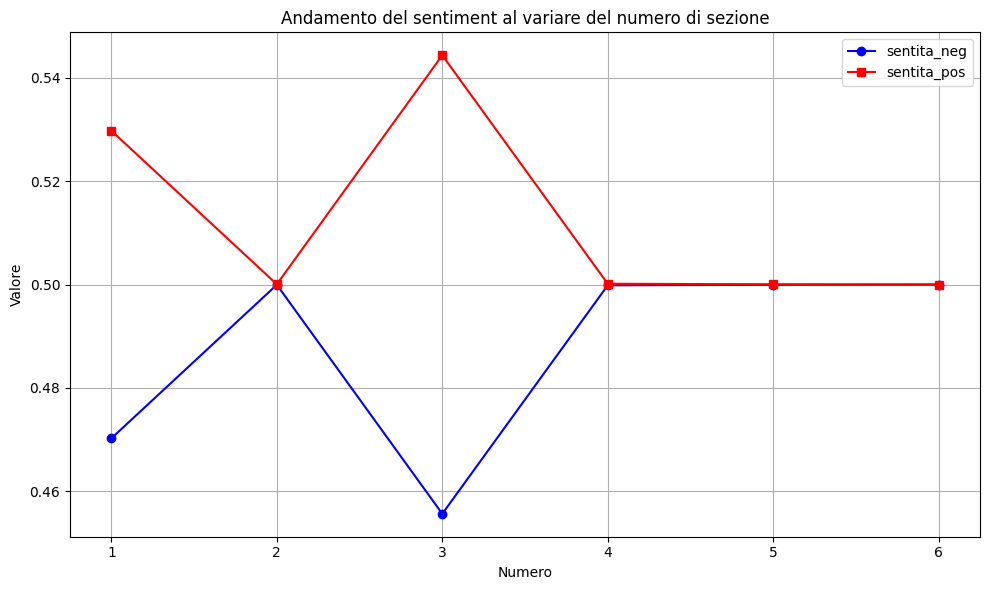

In [ ]:
res_sentITA_morf= senITA(df_morfina)

In [ ]:
res_sentITA_morf

Numero  sentita_neg  sentita_pos  \
0      1     0.470235     0.529765   
1      2     0.499951     0.500049   
2      3     0.455624     0.544376   
3      4     0.499850     0.500150   
4      5     0.499956     0.500044   
5      6     0.499999     0.500001   

                                             Sezione  \
0  che cos’è morfina cloridrato s.a.l.f. e a cosa...   
1  cosa deve sapere prima di usare morfina clorid...   
2             come usare morfina cloridrato s.a.l.f.   
3                     possibili effetti indesiderati   
4        come conservare morfina cloridrato s.a.l.f.   
5    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  morfina cloridrato contiene principio attivo m...  
1  morfina cloridrato allergico morfina cloridrat...  
2  medicinale somministrato medico infermiere pel...  
3  medicinali medicinale causare effetti indeside...  
4  conservi medicinale portata vista bambini medi...  
5  contiene morfina cloridrato morfina cloridrato...

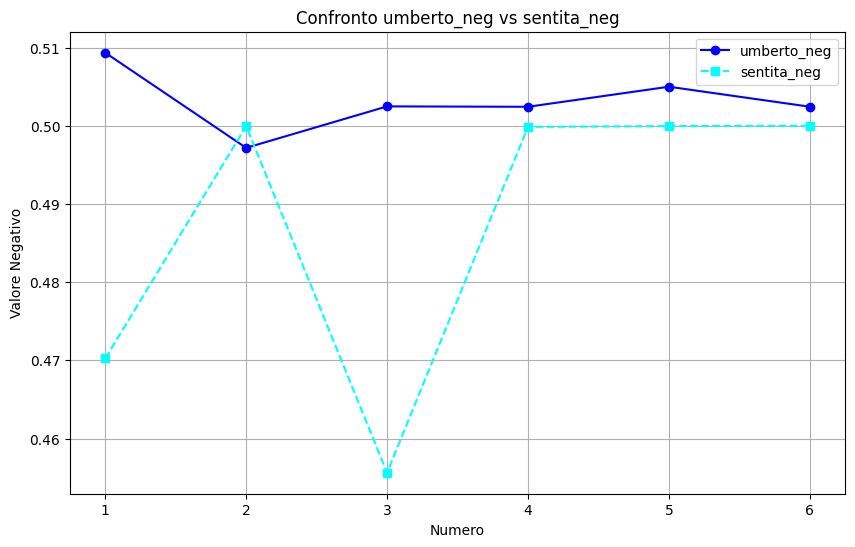

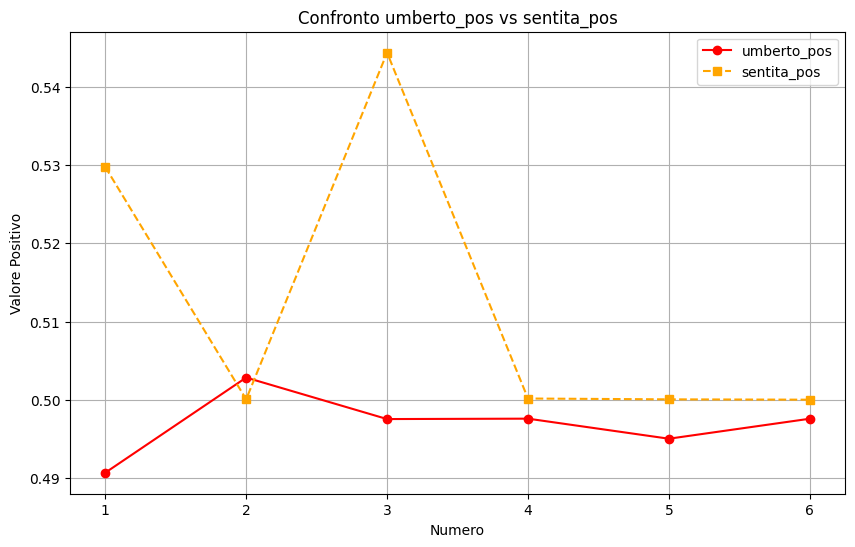

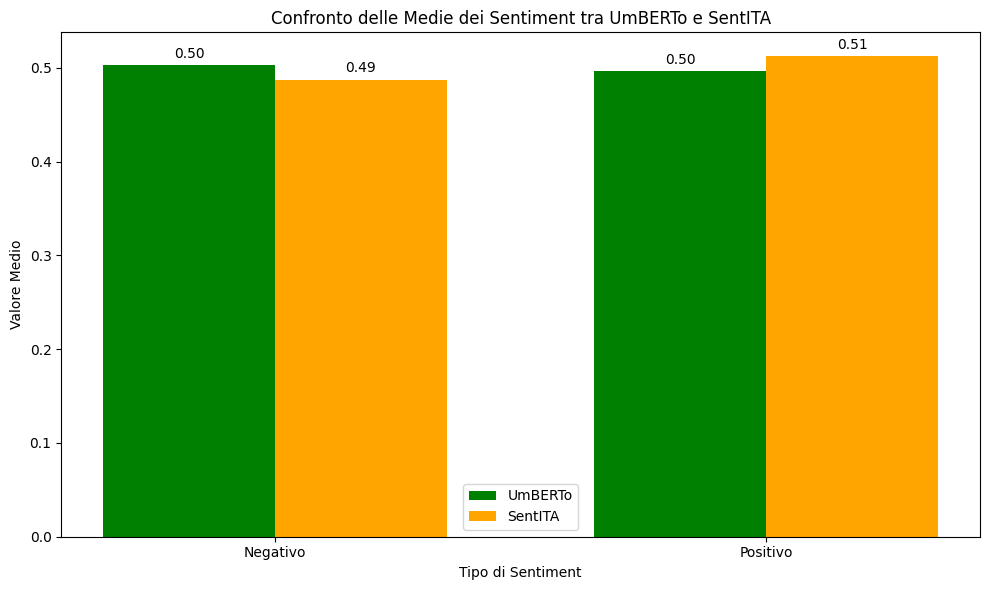

In [ ]:
umBERTo_vs_sentITA(res_umBERTO_morf, res_sentITA_morf)

### FEEL-IT



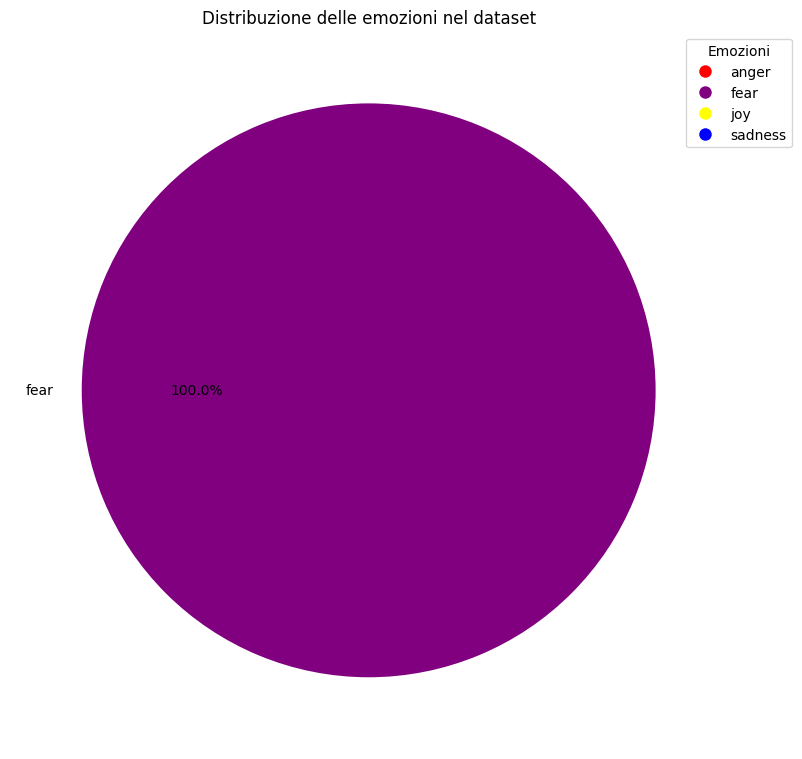

In [46]:
res_Feelit_morf= Feel_it(df_morfina)

In [26]:
res_Feelit_morf

Numero Emotion                                            Sezione  \
0      1    fear  che cos’è morfina cloridrato s.a.l.f. e a cosa...   
1      2    fear  cosa deve sapere prima di usare morfina clorid...   
2      3    fear             come usare morfina cloridrato s.a.l.f.   
3      4    fear                     possibili effetti indesiderati   
4      5    fear        come conservare morfina cloridrato s.a.l.f.   
5      6    fear    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  morfina cloridrato contiene principio attivo m...  
1  usi morfina cloridrato allergico morfina clori...  
2  medicinale somministrato medico infermiere pel...  
3  medicinali medicinale causare effetti indeside...  
4  conservi medicinale portata vista bambini usi ...  
5  contiene morfina cloridrato morfina cloridrato...

# Bisolvon


In [18]:
#Ricavo i possibili titoli dei paragrafi
paragrafi_titoli = titoli_paragrafi('Bisolvon')

pdf_file_bis= 'bisolvon.pdf'
# Cambia l'estensione del file da 'nomefile.pdf' a 'nomefile.csv'
nome_csv_bis= pdf_file_bis.replace(".pdf", ".csv")

# Chiamare la funzione con il file PDF e i titoli dei paragrafi
df_bisolvon = estrai_paragrafi_bugiardino(pdf_file_bis, paragrafi_titoli, linea_da_escludere, is_page_number)
print(df_bisolvon)

# Salvare il DataFrame in un file CSV
df_bisolvon.to_csv(nome_csv_bis, index=False, encoding='utf-8')

                                           Paragrafo  \
0               1. Che cos’è Bisolvon e a cosa serve   
1        2. Cosa deve sapere prima di usare Bisolvon   
2                             3. Come usare Bisolvon   
3                  4. Possibili effetti indesiderati   
4                        5. Come conservare Bisolvon   
5  6. Contenuto della confezione e altre informaz...   

                                           Contenuto  
0  Bisolvon contiene bromexina cloridrato, un muc...  
1  Non usi Bisolvon - se è allergico alla bromexi...  
2  Usi questo medicinale seguendo sempre esattame...  
3  Come tutti i medicinali, questo medicinale può...  
4  Questo medicinale non richiede alcuna particol...  
5  Cosa contiene Bisolvon - il principio attivo è...  


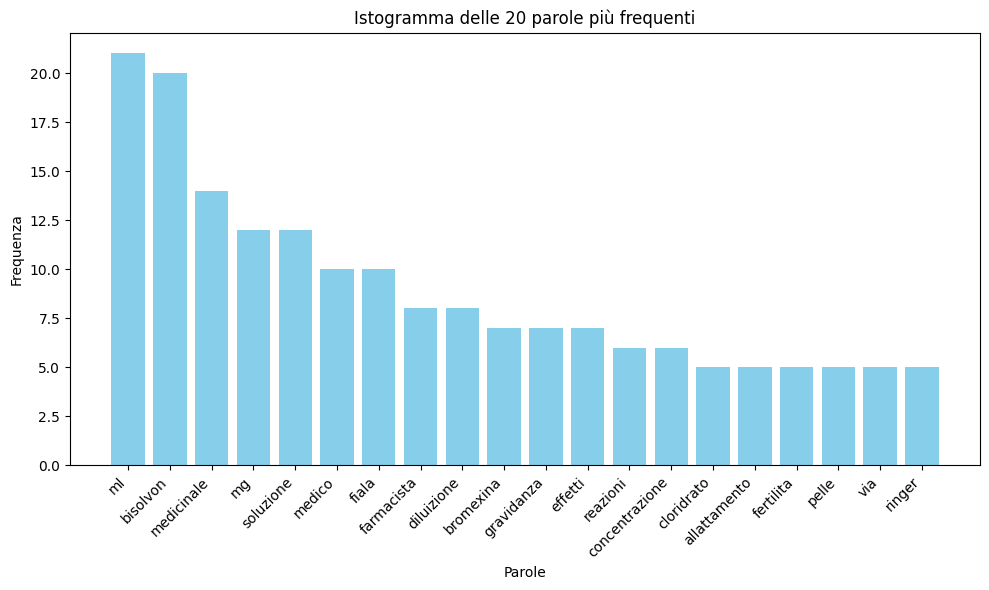

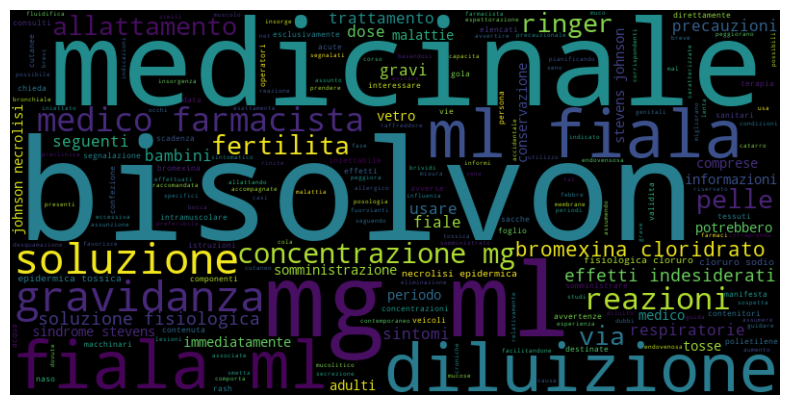

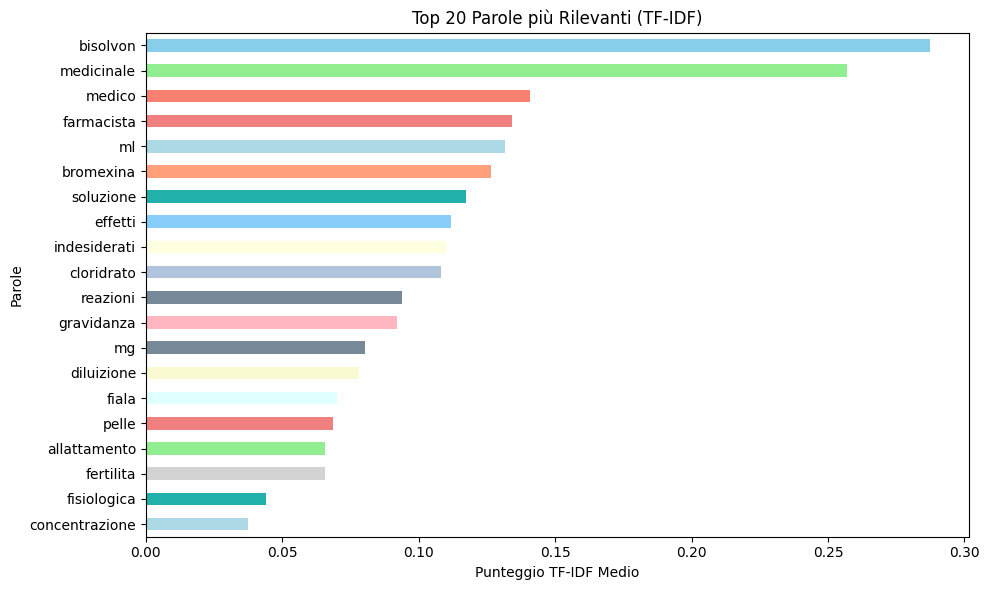

[(('mg', 'ml'), 10), (('ml', 'fiala'), 8), (('fiala', 'ml'), 8), (('medico', 'farmacista'), 7), (('concentrazione', 'mg'), 6), (('bromexina', 'cloridrato'), 5), (('soluzione', 'fisiologica'), 5), (('effetti', 'indesiderati'), 5), (('soluzione', 'ringer'), 4), (('diluizione', 'soluzione'), 4)]


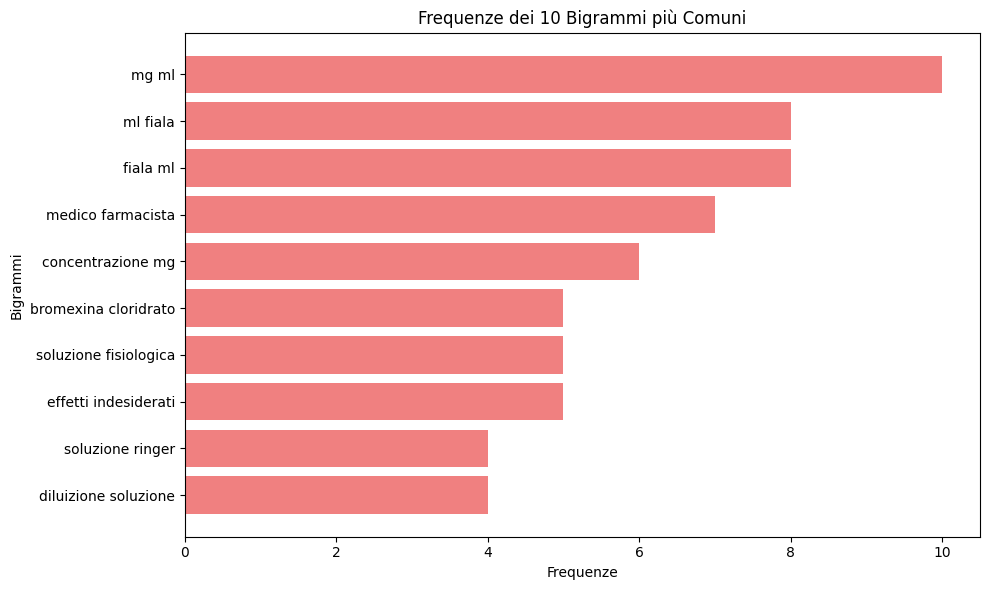

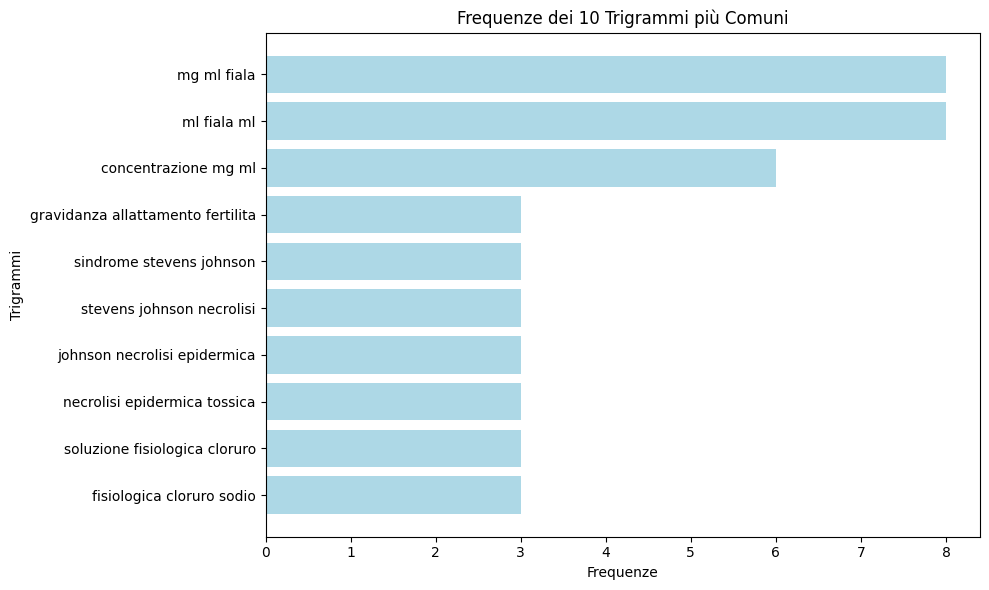

In [19]:
df_bisolvon= clean_stop_tok_graph(df_bisolvon, '')

In [20]:
df_bisolvon

Numero                                          Sezione  \
0      1                che cos’è bisolvon e a cosa serve   
1      2         cosa deve sapere prima di usare bisolvon   
2      3                              come usare bisolvon   
3      4                   possibili effetti indesiderati   
4      5                         come conservare bisolvon   
5      6  contenuto della confezione e altre informazioni   

                                           Contenuto  
0  bisolvon bromexina cloridrato mucolitico fluid...  
1  bisolvon allergico bromexina componenti medici...  
2  medicinale seguendo esattamente istruzioni med...  
3  medicinale causare effetti indesiderati sebben...  
4  medicinale richiede particolare condizione con...  
5  bisolvon principio attivo bromexina cloridrato...

## Sentiment e Emotions Analysis

### Vader


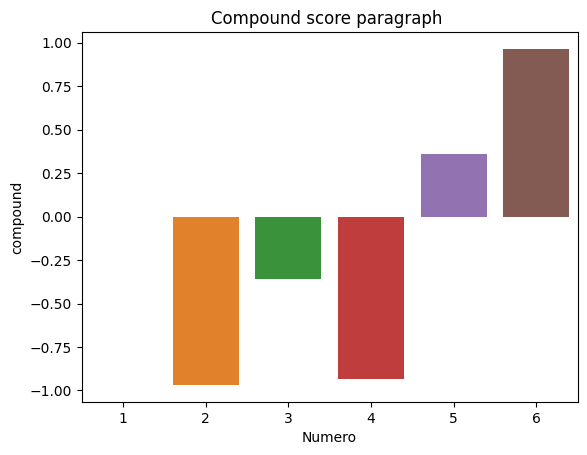

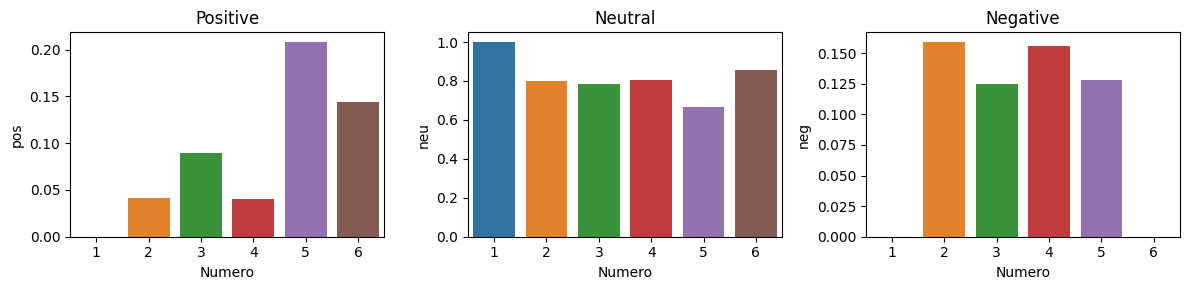

In [17]:
res_vaders_bis = vader(df_bisolvon)

In [18]:
res_vaders_bis

Numero    neg    neu    pos  compound  \
0      1  0.000  1.000  0.000    0.0000   
1      2  0.159  0.801  0.041   -0.9682   
2      3  0.125  0.787  0.089   -0.3612   
3      4  0.156  0.804  0.040   -0.9313   
4      5  0.128  0.664  0.208    0.3612   
5      6  0.000  0.856  0.144    0.9643   

                                           Sezione  \
0                che cos’è bisolvon e a cosa serve   
1         cosa deve sapere prima di usare bisolvon   
2                              come usare bisolvon   
3                   possibili effetti indesiderati   
4                         come conservare bisolvon   
5  contenuto della confezione e altre informazioni   

                                           Contenuto  
0  bisolvon bromexina cloridrato mucolitico fluid...  
1  bisolvon allergico bromexina componenti medici...  
2  medicinale seguendo esattamente istruzioni med...  
3  medicinale causare effetti indesiderati sebben...  
4  medicinale richiede particolare condizione con...  
5  bisolvon principio attivo bromexina cloridrato...

### UmBERTo

Some weights of the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and

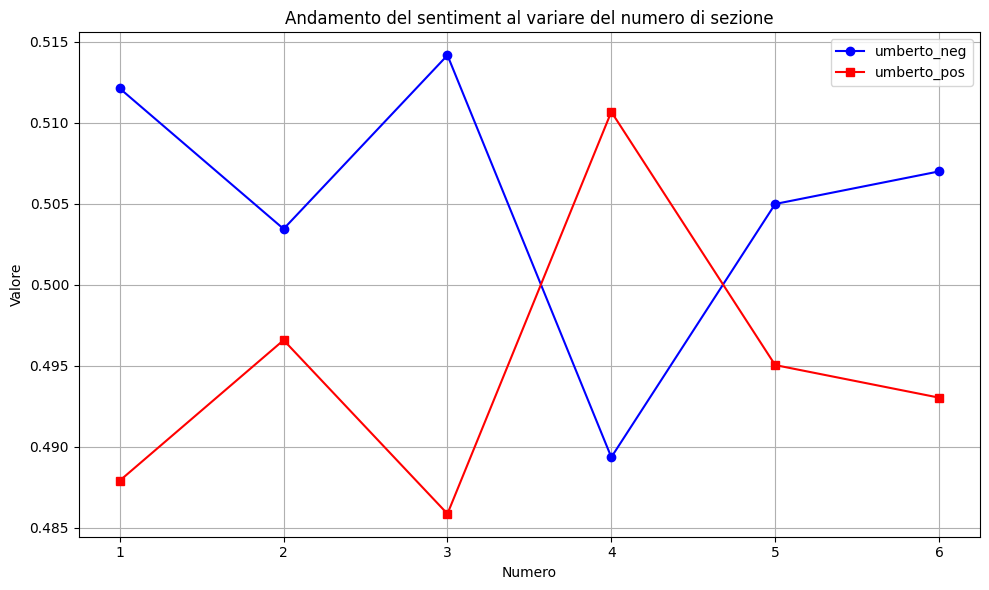

In [19]:
res_umBERTO_bis= umBERTo(df_bisolvon) 

In [21]:
res_umBERTO_bis

Numero  umberto_neg  umberto_pos  \
0      1     0.512106     0.487894   
1      2     0.503433     0.496567   
2      3     0.514153     0.485847   
3      4     0.489339     0.510661   
4      5     0.504972     0.495028   
5      6     0.506983     0.493017   

                                           Sezione  \
0                che cos’è bisolvon e a cosa serve   
1         cosa deve sapere prima di usare bisolvon   
2                              come usare bisolvon   
3                   possibili effetti indesiderati   
4                         come conservare bisolvon   
5  contenuto della confezione e altre informazioni   

                                           Contenuto  
0  bisolvon bromexina cloridrato mucolitico fluid...  
1  bisolvon allergico bromexina componenti medici...  
2  medicinale seguendo esattamente istruzioni med...  
3  medicinale causare effetti indesiderati sebben...  
4  medicinale richiede particolare condizione con...  
5  bisolvon principio attivo bromexina cloridrato...

### SentITA


c:\ProgramData\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step

bisolvon bromexina cloridrato mucolitico fluidifica muco vie respiratorie facilitandone eliminazione bisolvon indicato trattamento malattie respiratorie acute insorgenza croniche accompagnate tosse catarro adulti  - opos:  0.0071553662  - oneg:  0.18647681
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
bisolvon allergico bromexina componenti medicinale elencati  allattando seno  gravidanza allattamento fertilita avvertenze precauzioni medico farmacista usare bisolvon malattia vie respiratorie insorge peggiora periodo relativamente breve condizioni respiratorie acute consulti medico sintomi migliorano peggiorano corso terapia gravidanza  gravidanza allattamento fertilita bambini medicinale riservato adulti segnalati casi reazioni cutanee gravi associate somministrazione bromexina cloridrato manifesta rash cutaneo comprese lesioni membrane mucose bocca gola naso occhi genitali smetta prendere bisolvon immediatamente medico reazioni potrebbero sintomi gravi

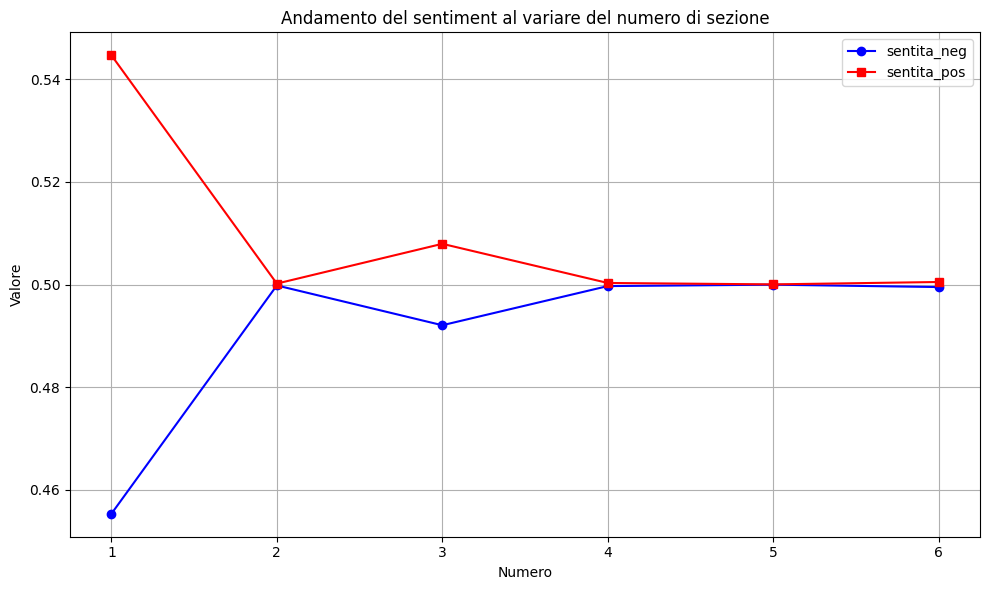

In [22]:
res_sentITA_bis= senITA(df_bisolvon)

In [24]:
res_sentITA_bis

Numero  sentita_neg  sentita_pos  \
0      1     0.455289     0.544711   
1      2     0.499818     0.500182   
2      3     0.492061     0.507939   
3      4     0.499696     0.500304   
4      5     0.499971     0.500029   
5      6     0.499506     0.500494   

                                           Sezione  \
0                che cos’è bisolvon e a cosa serve   
1         cosa deve sapere prima di usare bisolvon   
2                              come usare bisolvon   
3                   possibili effetti indesiderati   
4                         come conservare bisolvon   
5  contenuto della confezione e altre informazioni   

                                           Contenuto  
0  bisolvon bromexina cloridrato mucolitico fluid...  
1  bisolvon allergico bromexina componenti medici...  
2  medicinale seguendo esattamente istruzioni med...  
3  medicinale causare effetti indesiderati sebben...  
4  medicinale richiede particolare condizione con...  
5  bisolvon principio attivo bromexina cloridrato...

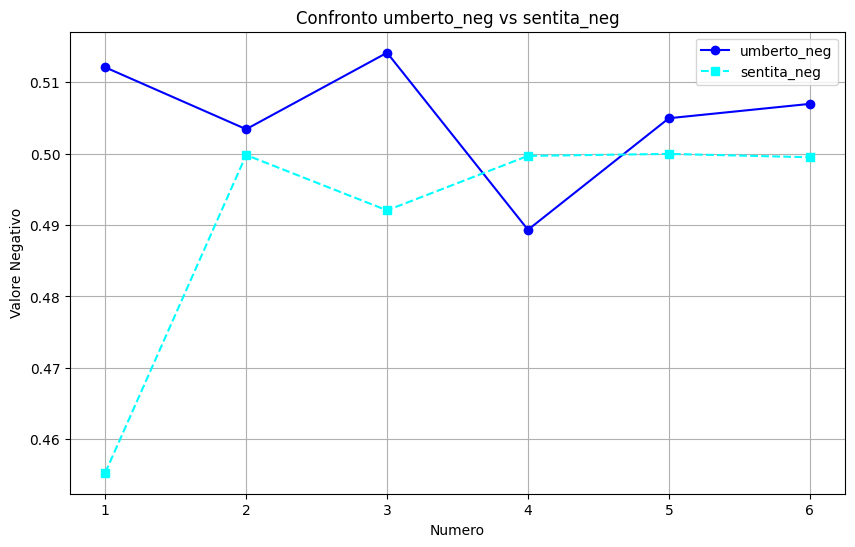

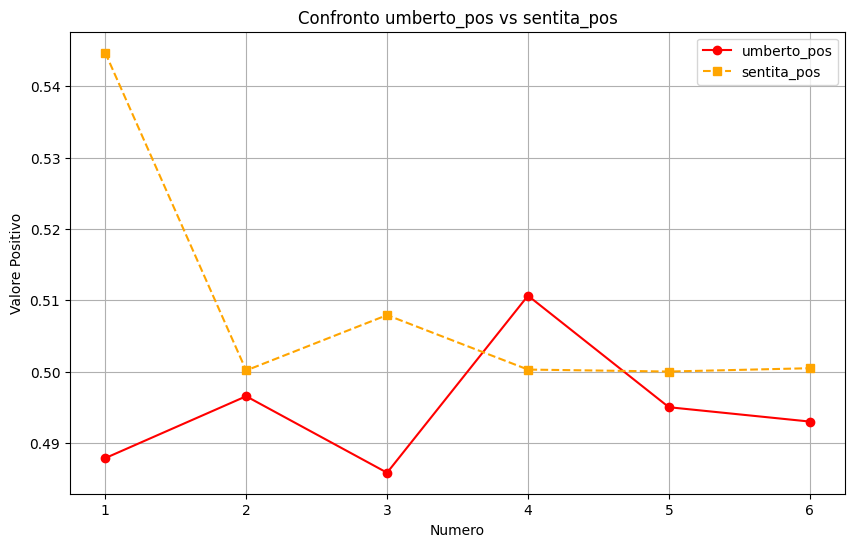

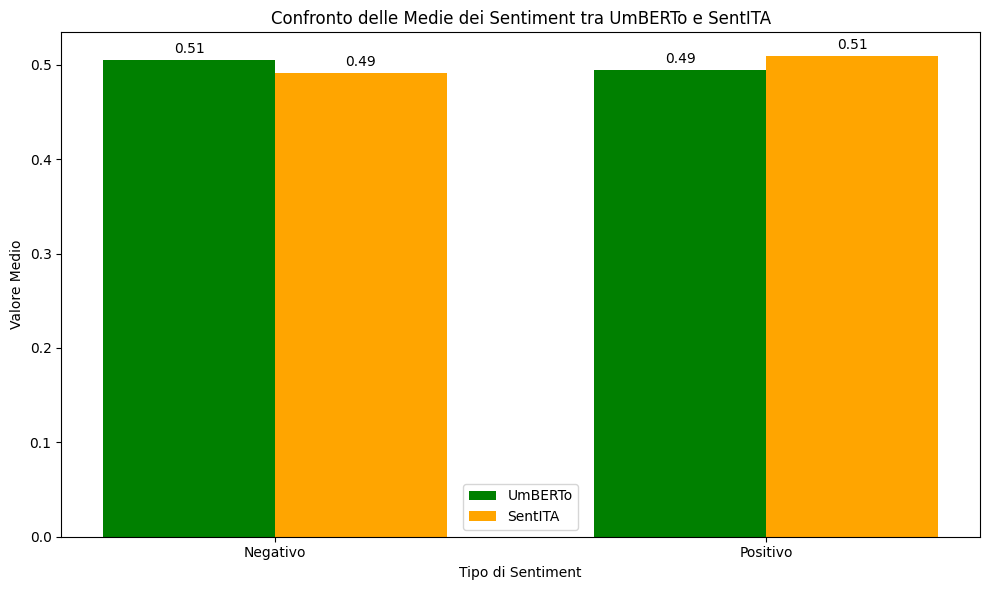

In [23]:
umBERTo_vs_sentITA(res_umBERTO_bis, res_sentITA_bis)

### FEEL-IT



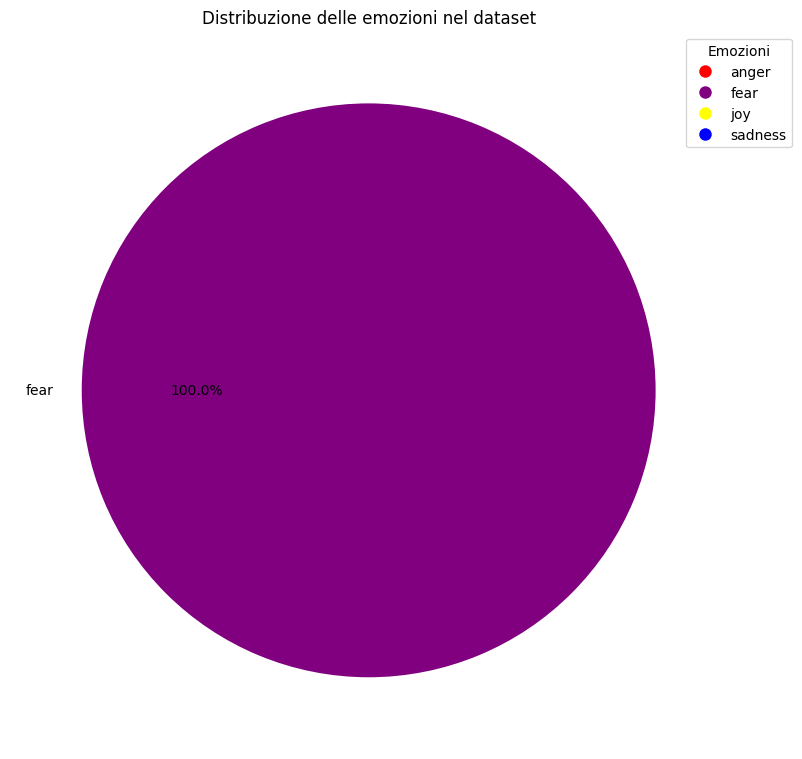

In [25]:
res_Feelit_bis= Feel_it(df_bisolvon)

In [42]:
res_Feelit_bis

Numero Emotion                                          Sezione  \
0      1    fear                che cos’è bisolvon e a cosa serve   
1      2    fear         cosa deve sapere prima di usare bisolvon   
2      3    fear                              come usare bisolvon   
3      4    fear                   possibili effetti indesiderati   
4      5    fear                         come conservare bisolvon   
5      6    fear  contenuto della confezione e altre informazioni   

                                           Contenuto  
0  bisolvon contiene bromexina cloridrato mucolit...  
1  usi bisolvon allergico bromexina qualsiasi com...  
2  usi medicinale seguendo esattamente istruzioni...  
3  medicinali medicinale causare effetti indeside...  
4  medicinale richiede particolare condizione con...  
5  contiene bisolvon principio attivo bromexina c...

# Borocillina

In [21]:
#Ricavo i possibili titoli dei paragrafi
paragrafi_titoli = titoli_paragrafi('Neo Borocillina Infiammazione e Dolore')

pdf_file_bor= 'borocillina.pdf'
# Cambia l'estensione del file da 'nomefile.pdf' a 'nomefile.csv'
nome_csv_bor= pdf_file_bor.replace(".pdf", ".csv")

# Chiamare la funzione con il file PDF e i titoli dei paragrafi
df_borocillina = estrai_paragrafi_bugiardino(pdf_file_bor, paragrafi_titoli, linea_da_escludere, is_page_number)
print(df_borocillina)

# Salvare il DataFrame in un file CSV
df_borocillina.to_csv(nome_csv_bor, index=False, encoding='utf-8')

                                           Paragrafo  \
0  1. Che cos’è Neo Borocillina Infiammazione e D...   
1  2. Cosa deve sapere prima di prendere Neo Boro...   
2  3. Come prendere Neo Borocillina Infiammazione...   
3                  4. Possibili effetti indesiderati   
4  5. Come conservare Neo Borocillina Infiammazio...   
5  6. Contenuto della confezione e altre informaz...   

                                           Contenuto  
0  Neo Borocillina Infiammazione e Dolore contien...  
1  Non prenda Neo Borocillina Infiammazione e Dol...  
2  Prenda questo medicinale seguendo sempre esatt...  
3  Come tutti i medicinali, questo medicinale può...  
4  Conservi questo medicinale fuori dalla vista e...  
5  Cosa contiene Neo Borocillina Infiammazione e ...  


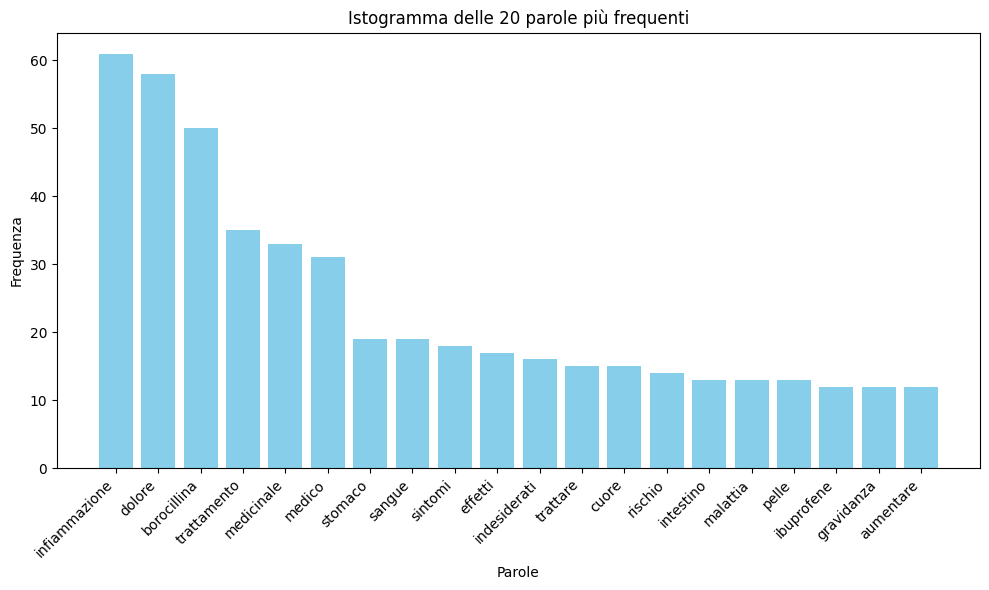

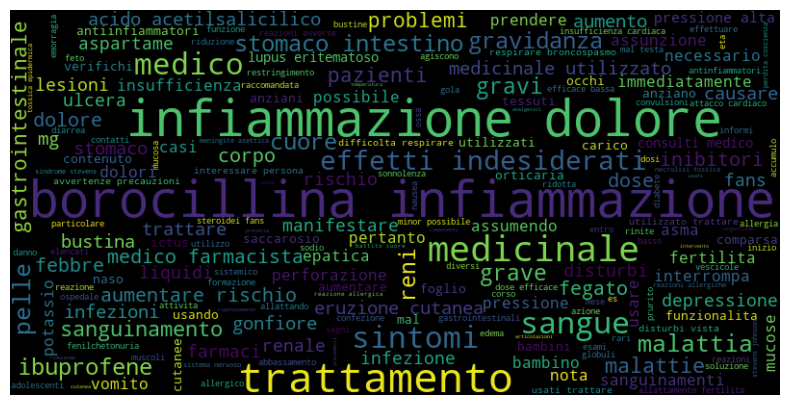

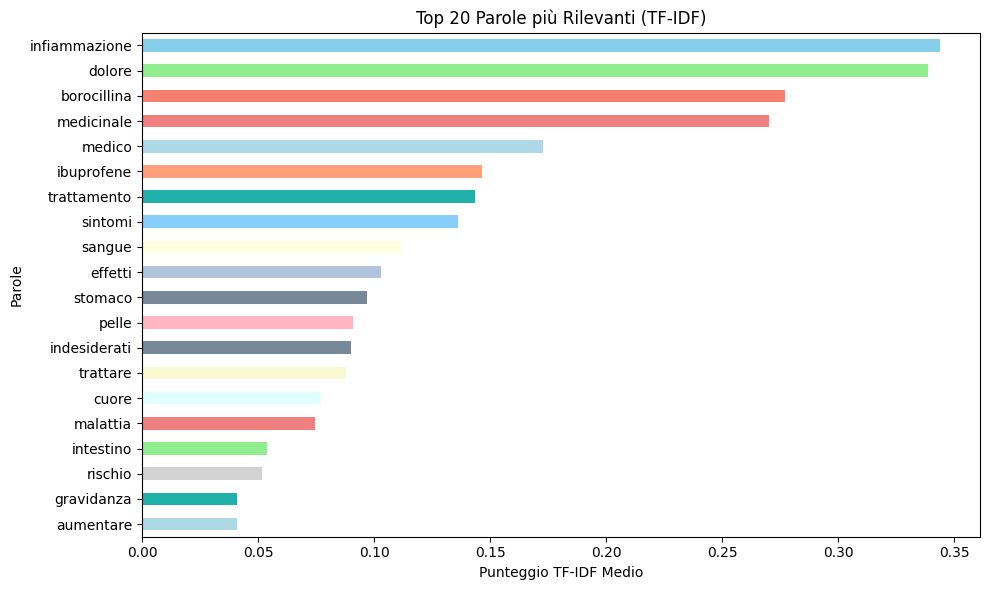

[(('borocillina', 'infiammazione'), 50), (('infiammazione', 'dolore'), 50), (('effetti', 'indesiderati'), 16), (('stomaco', 'intestino'), 12), (('medico', 'farmacista'), 8), (('aumentare', 'rischio'), 8), (('acido', 'acetilsalicilico'), 7), (('eruzione', 'cutanea'), 7), (('trattamento', 'borocillina'), 7), (('medicinale', 'utilizzato'), 7)]


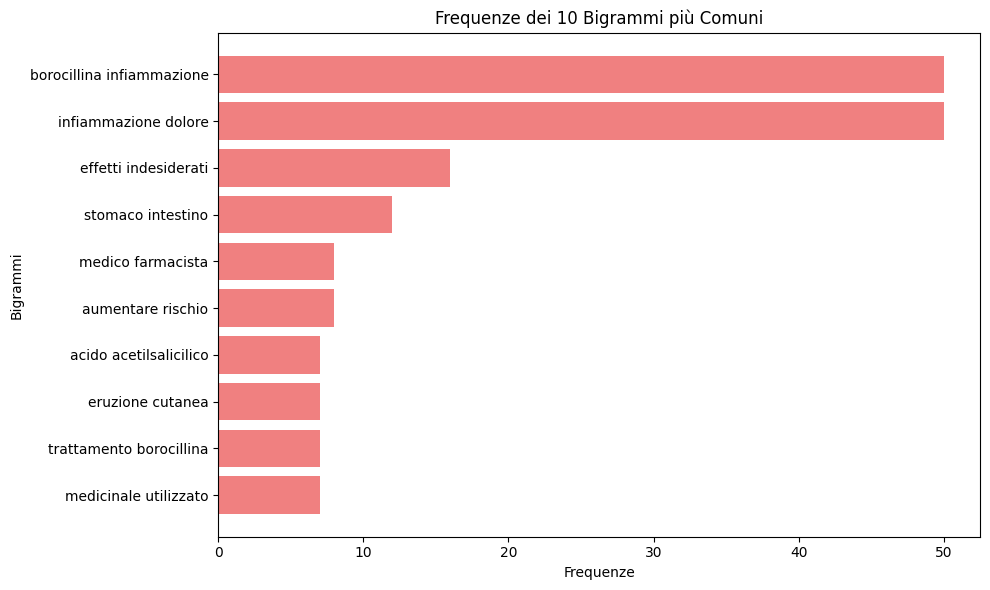

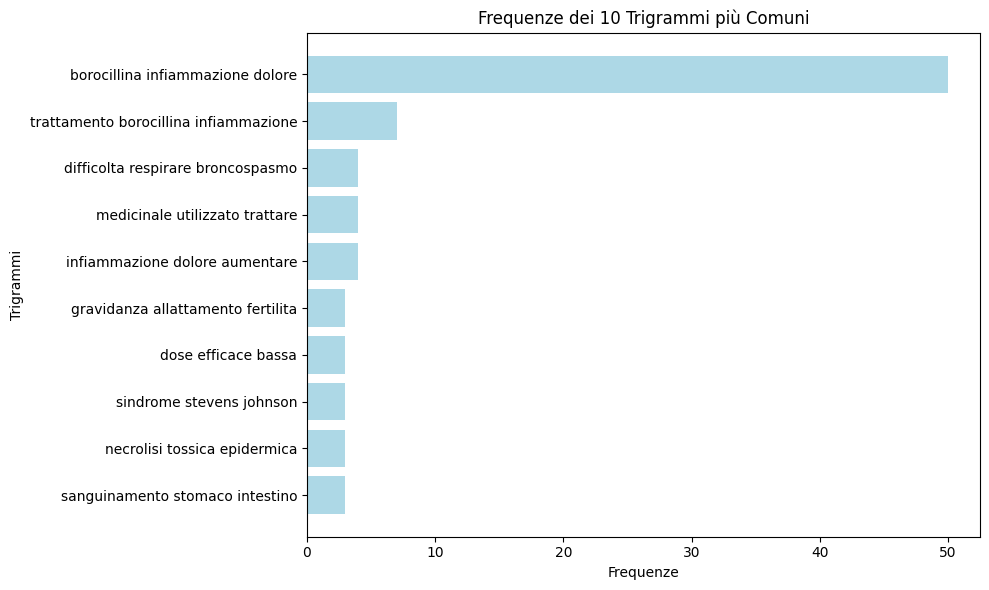

In [22]:
df_borocillina= clean_stop_tok_graph(df_borocillina, 'neo')

In [23]:
df_borocillina

Numero                                            Sezione  \
0      1  che cos’è neo borocillina infiammazione e dolo...   
1      2  cosa deve sapere prima di prendere neo borocil...   
2      3  come prendere neo borocillina infiammazione e ...   
3      4                     possibili effetti indesiderati   
4      5  come conservare neo borocillina infiammazione ...   
5      6    contenuto della confezione e altre informazioni   

                                           Contenuto  
0   borocillina infiammazione dolore principio at...  
1   borocillina infiammazione dolore allergico ib...  
2  medicinale seguendo esattamente riportato fogl...  
3  medicinale causare effetti indesiderati sebben...  
4  conservi medicinale vista portata bambini medi...  
5   borocillina infiammazione dolore principio at...

## Sentiment e Emotions Analysis

### Vader


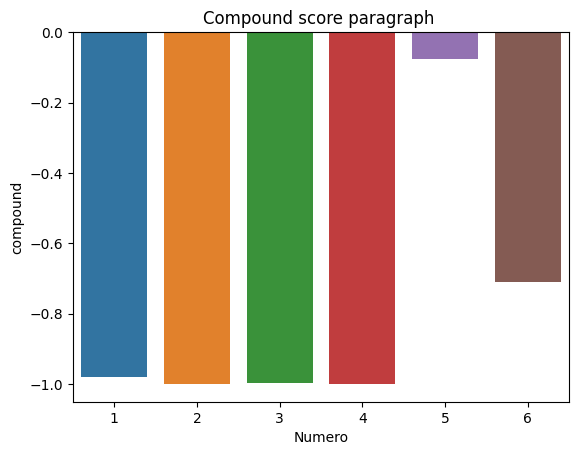

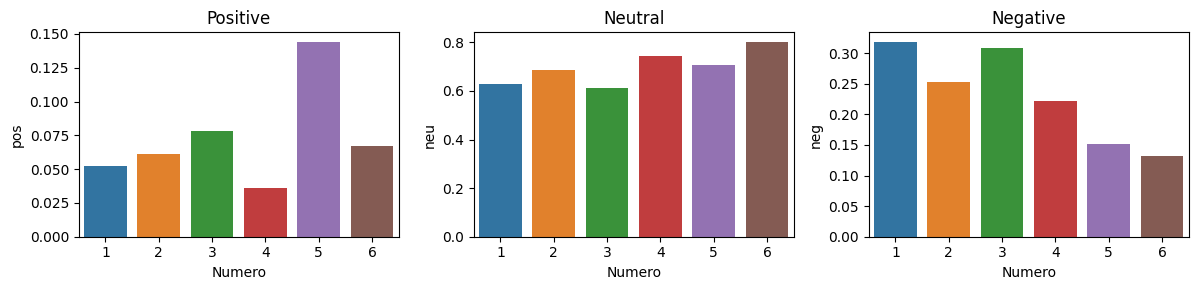

In [29]:
res_vaders_bor = vader(df_borocillina)

In [30]:
res_vaders_bor

Numero    neg    neu    pos  compound  \
0      1  0.318  0.629  0.052   -0.9788   
1      2  0.253  0.685  0.061   -0.9998   
2      3  0.309  0.613  0.078   -0.9976   
3      4  0.222  0.742  0.036   -0.9990   
4      5  0.152  0.705  0.144   -0.0772   
5      6  0.132  0.801  0.067   -0.7096   

                                             Sezione  \
0  che cos’è neo borocillina infiammazione e dolo...   
1  cosa deve sapere prima di prendere neo borocil...   
2  come prendere neo borocillina infiammazione e ...   
3                     possibili effetti indesiderati   
4  come conservare neo borocillina infiammazione ...   
5    contenuto della confezione e altre informazioni   

                                           Contenuto  
0   borocillina infiammazione dolore principio at...  
1   borocillina infiammazione dolore allergico ib...  
2  medicinale seguendo esattamente riportato fogl...  
3  medicinale causare effetti indesiderati sebben...  
4  conservi medicinale vista portata bambini medi...  
5   borocillina infiammazione dolore principio at...

### UmBERTo

Some weights of the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and

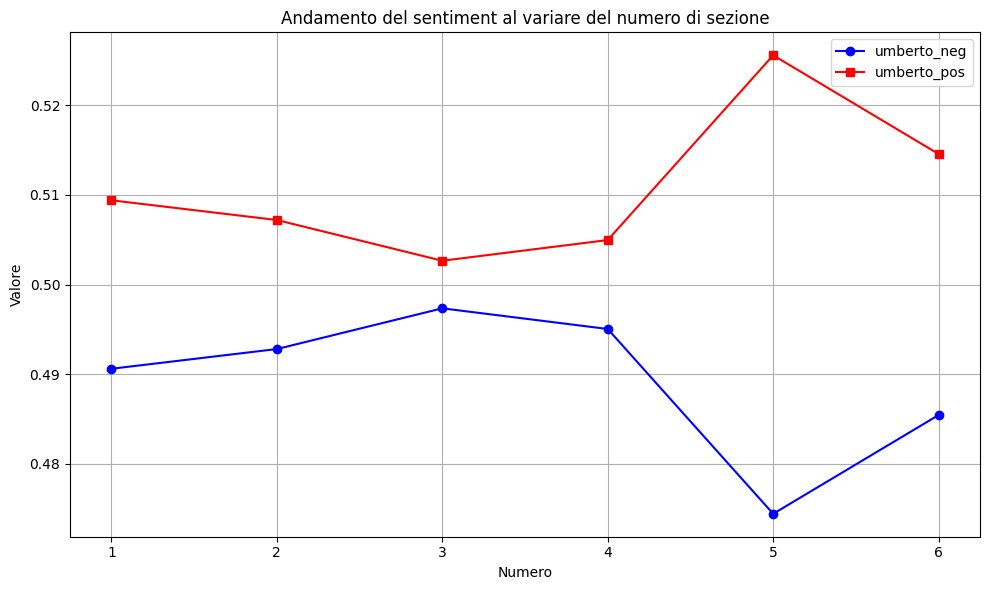

In [31]:
res_umBERTO_bor = umBERTo(df_borocillina) 

In [33]:
res_umBERTO_bor

Numero  umberto_neg  umberto_pos  \
0      1     0.490594     0.509406   
1      2     0.492796     0.507204   
2      3     0.497343     0.502657   
3      4     0.495035     0.504965   
4      5     0.474401     0.525599   
5      6     0.485430     0.514570   

                                             Sezione  \
0  che cos’è neo borocillina infiammazione e dolo...   
1  cosa deve sapere prima di prendere neo borocil...   
2  come prendere neo borocillina infiammazione e ...   
3                     possibili effetti indesiderati   
4  come conservare neo borocillina infiammazione ...   
5    contenuto della confezione e altre informazioni   

                                           Contenuto  
0   borocillina infiammazione dolore principio at...  
1   borocillina infiammazione dolore allergico ib...  
2  medicinale seguendo esattamente riportato fogl...  
3  medicinale causare effetti indesiderati sebben...  
4  conservi medicinale vista portata bambini medi...  
5   borocillina infiammazione dolore principio at...

### SentITA


c:\ProgramData\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
 borocillina infiammazione dolore principio attivo ibuprofene appartiene classe noti antinfiammatori antireumatici steroidei fans agiscono riducendo dolore azione analgesica infiammazione azione antinfiammatoria abbassando temperatura corporea febbre azione antipiretica  borocillina infiammazione dolore usa trattare dolori origine natura mal gola corso faringite faringo tonsillite post tonsillectomia intervento chirurgico asportazione tonsille mal testa mal denti nevralgie dolori ossa articolazioni muscoli dolori osteoarticolari dolori mestruali sintomi febbre influenza medico sente sente  trattamento disturbo presenta ripetutamente notato cambiamento caratteristiche  - opos:  0.005365354  - oneg:  0.3188645
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
 borocillina infiammazione dolore allergico ibuprofene componenti medicinale elencati  allergico acido acetilsalicilico usati ridurre dolore analgesici antifebbrili antipiretici antiinfiammatori steroidei

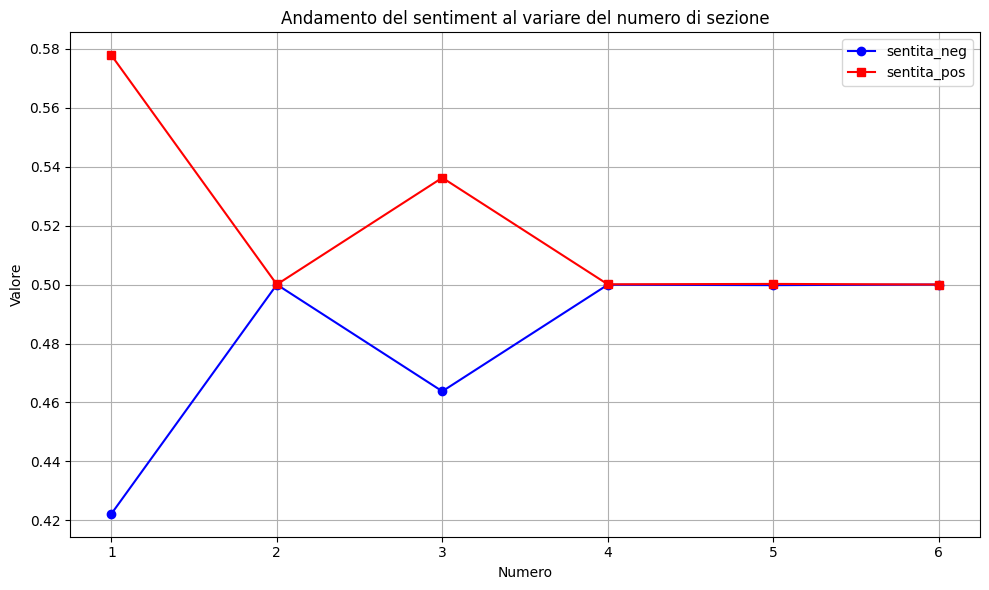

In [34]:
res_sentITA_bor= senITA(df_borocillina)

In [35]:
res_sentITA_bor

Numero  sentita_neg  sentita_pos  \
0      1     0.422261     0.577739   
1      2     0.499984     0.500016   
2      3     0.463795     0.536205   
3      4     0.499927     0.500073   
4      5     0.499795     0.500205   
5      6     0.499998     0.500002   

                                             Sezione  \
0  che cos’è neo borocillina infiammazione e dolo...   
1  cosa deve sapere prima di prendere neo borocil...   
2  come prendere neo borocillina infiammazione e ...   
3                     possibili effetti indesiderati   
4  come conservare neo borocillina infiammazione ...   
5    contenuto della confezione e altre informazioni   

                                           Contenuto  
0   borocillina infiammazione dolore principio at...  
1   borocillina infiammazione dolore allergico ib...  
2  medicinale seguendo esattamente riportato fogl...  
3  medicinale causare effetti indesiderati sebben...  
4  conservi medicinale vista portata bambini medi...  
5   borocillina infiammazione dolore principio at...

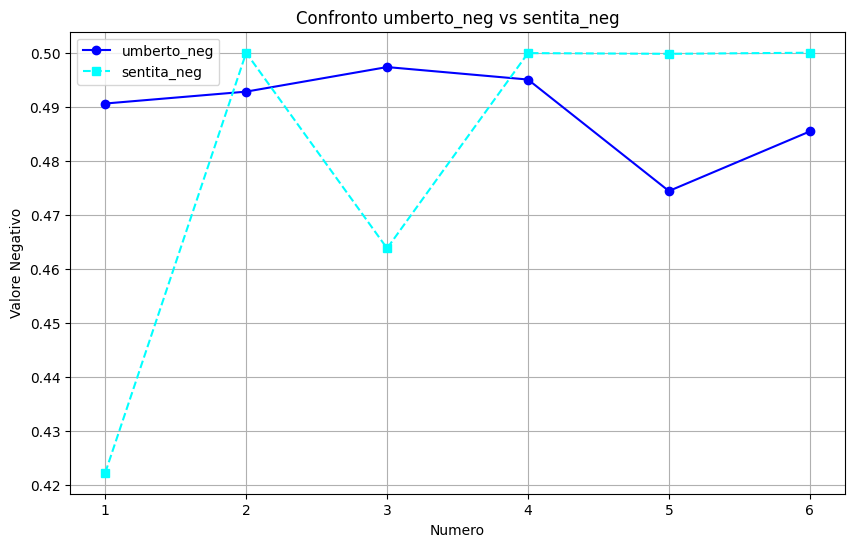

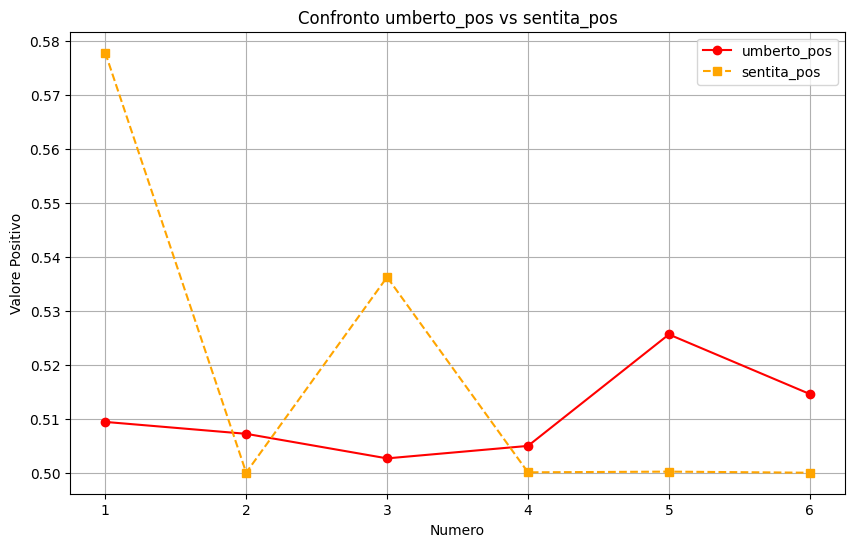

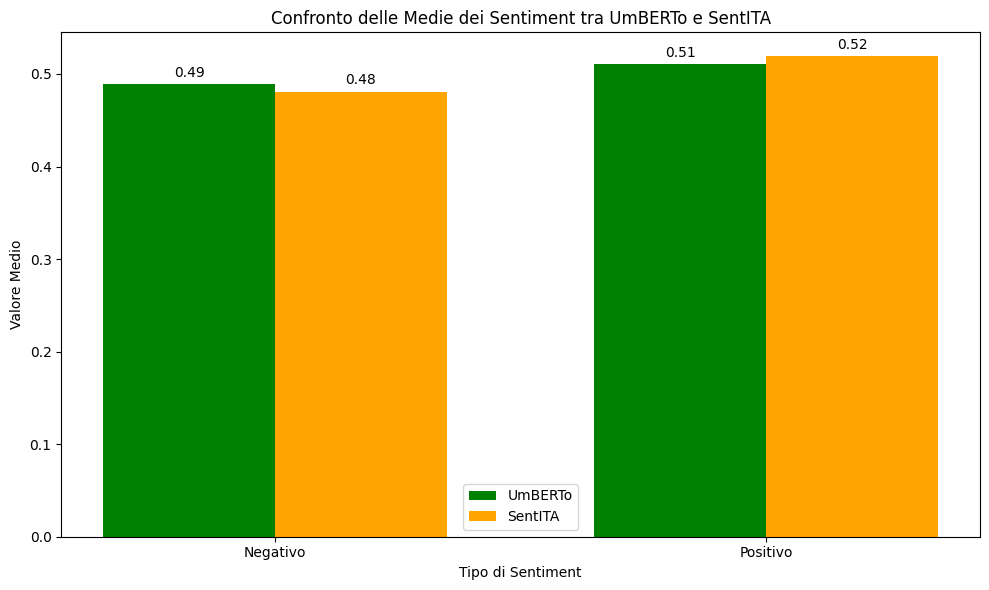

In [36]:
umBERTo_vs_sentITA(res_umBERTO_bor, res_sentITA_bor)

### FEEL-IT



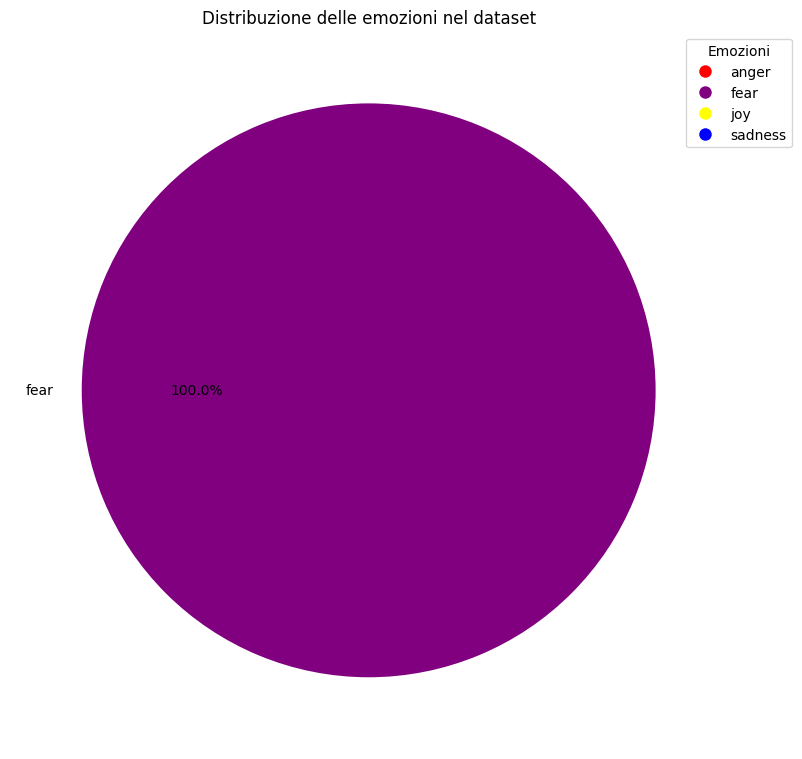

In [37]:
res_Feelit_bor= Feel_it(df_borocillina)

In [38]:
res_Feelit_bor

Numero Emotion                                            Sezione  \
0      1    fear  che cos’è neo borocillina infiammazione e dolo...   
1      2    fear  cosa deve sapere prima di prendere neo borocil...   
2      3    fear  come prendere neo borocillina infiammazione e ...   
3      4    fear                     possibili effetti indesiderati   
4      5    fear  come conservare neo borocillina infiammazione ...   
5      6    fear    contenuto della confezione e altre informazioni   

                                           Contenuto  
0   borocillina infiammazione dolore principio at...  
1   borocillina infiammazione dolore allergico ib...  
2  medicinale seguendo esattamente riportato fogl...  
3  medicinale causare effetti indesiderati sebben...  
4  conservi medicinale vista portata bambini medi...  
5   borocillina infiammazione dolore principio at...

# Dicloreum

In [24]:
#Ricavo i possibili titoli dei paragrafi
paragrafi_titoli = titoli_paragrafi('Dicloreum dolore')

pdf_file_dicl= 'dicloreum.pdf'
# Cambia l'estensione del file da 'nomefile.pdf' a 'nomefile.csv'
nome_csv_dicl= pdf_file_dicl.replace(".pdf", ".csv")

# Chiamare la funzione con il file PDF e i titoli dei paragrafi
df_dicloreum = estrai_paragrafi_bugiardino(pdf_file_dicl, paragrafi_titoli, linea_da_escludere, is_page_number)
print(df_dicloreum)

# Salvare il DataFrame in un file CSV
df_dicloreum.to_csv(nome_csv_dicl, index=False, encoding='utf-8')

                                           Paragrafo  \
0           1. Cos’è Dicloreum dolore e a cosa serve   
1  2. Cosa deve sapere prima di prendere Dicloreu...   
2                  3. Come prendere Dicloreum dolore   
3                  4. Possibili effetti indesiderati   
4                5. Come conservare Dicloreum dolore   
5  6. Contenuto della confezione e altre informaz...   

                                           Contenuto  
0  Dicloreum dolore contiene il principio attivo ...  
1  Non prenda Dicloreum dolore • se è allergico a...  
2  Prenda questo medicinale seguendo sempre esatt...  
3  Come tutti i medicinali, questo medicinale può...  
4  Conservare a temperatura inferiore a 30°C. Con...  
5  Cosa contiene Dicloreum dolore - Il principio ...  


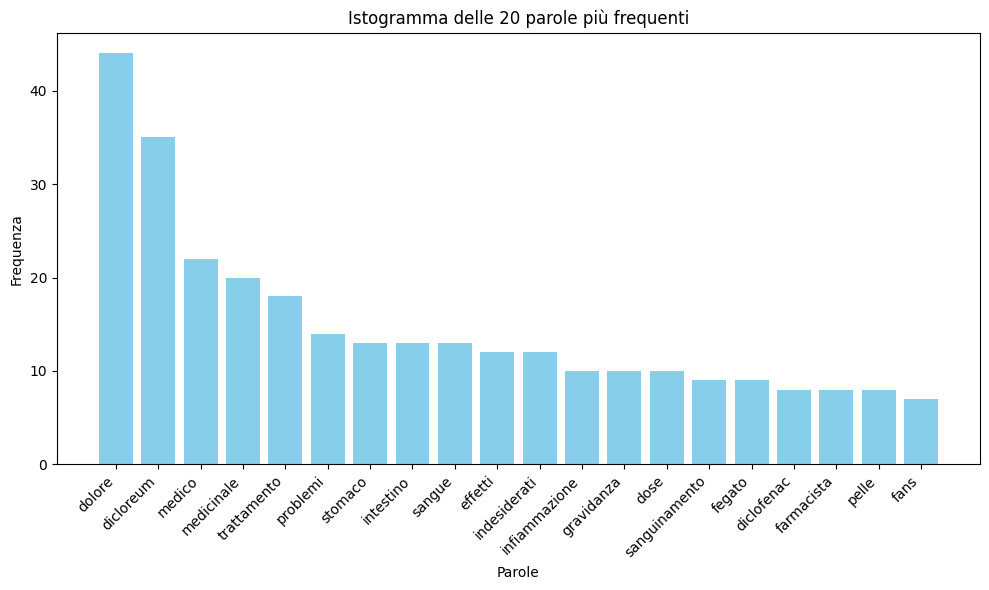

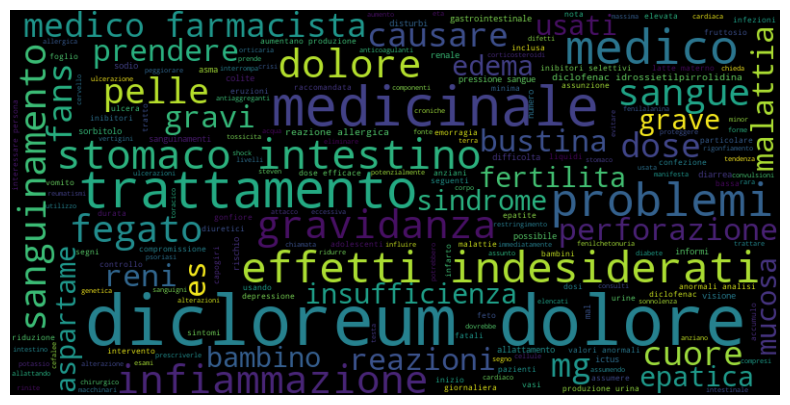

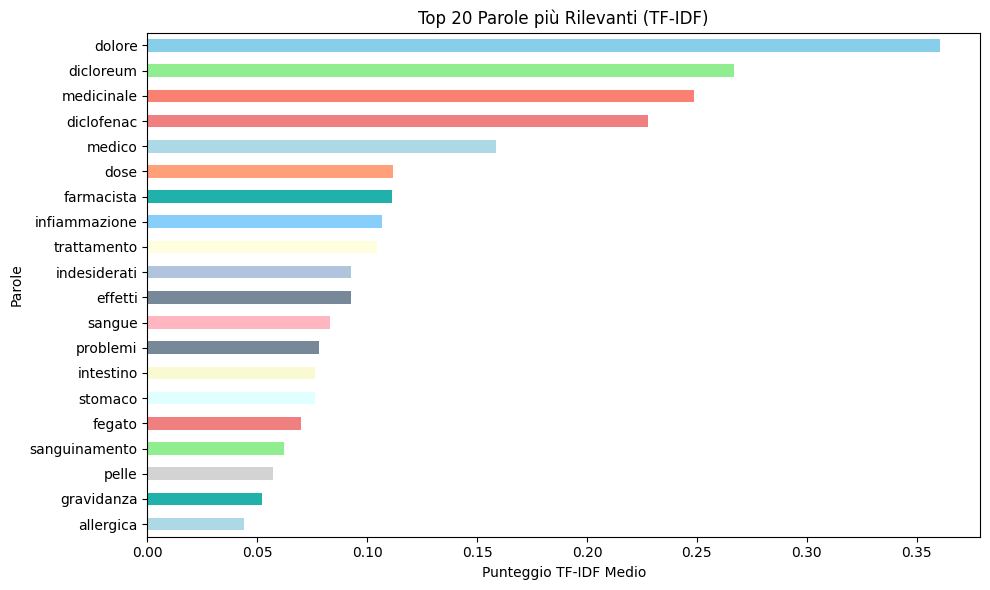

[(('dicloreum', 'dolore'), 34), (('effetti', 'indesiderati'), 12), (('stomaco', 'intestino'), 11), (('medico', 'farmacista'), 7), (('diclofenac', 'idrossietilpirrolidina'), 5), (('reazione', 'allergica'), 5), (('prendere', 'dicloreum'), 4), (('pressione', 'sangue'), 4), (('sanguinamento', 'perforazione'), 3), (('latte', 'materno'), 3)]


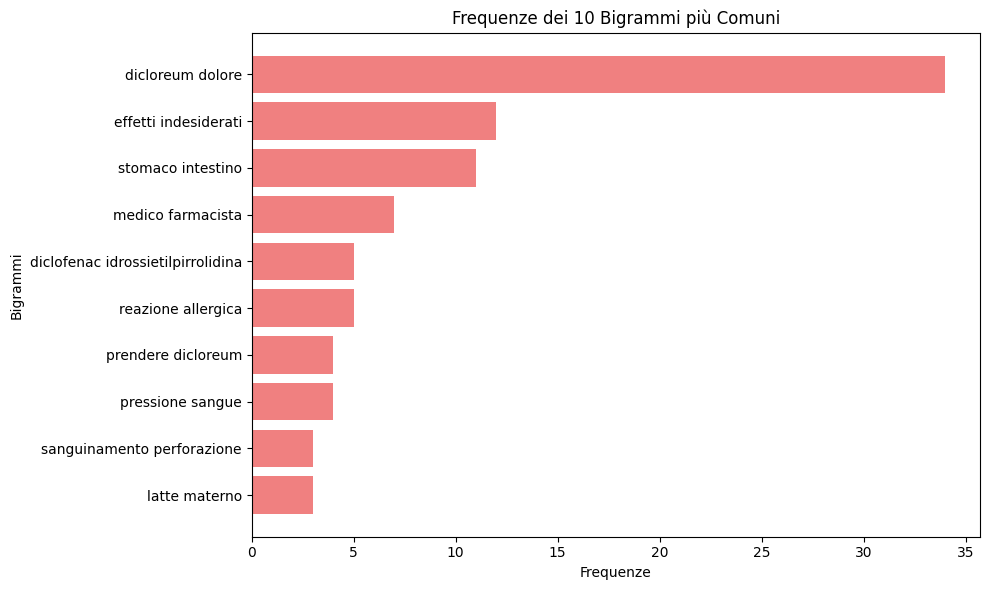

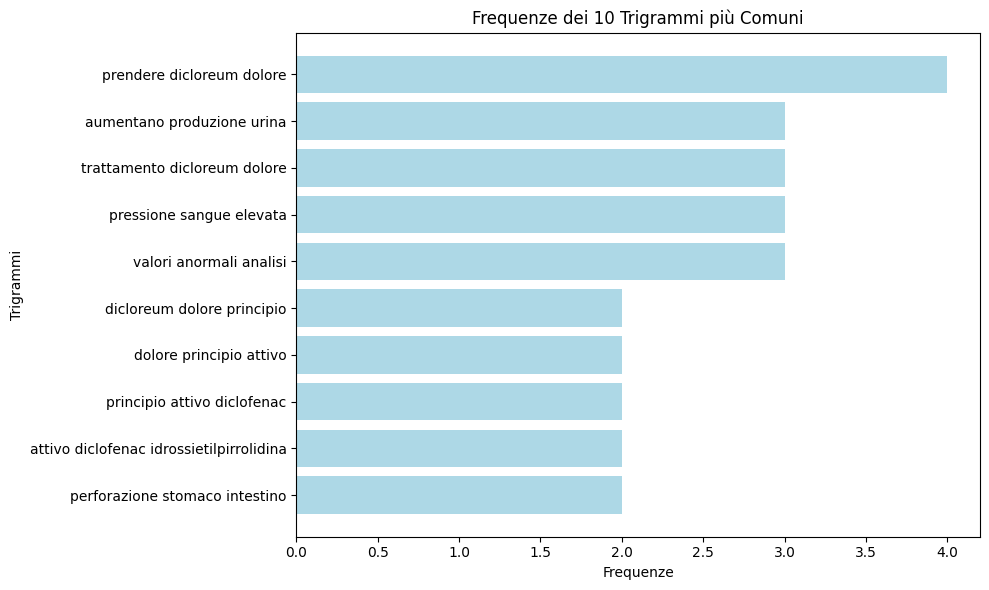

In [25]:
df_dicloreum= clean_stop_tok_graph(df_dicloreum, '')

In [26]:
df_dicloreum

Numero                                            Sezione  \
0      1              cos’è dicloreum dolore e a cosa serve   
1      2  cosa deve sapere prima di prendere dicloreum d...   
2      3                     come prendere dicloreum dolore   
3      4                     possibili effetti indesiderati   
4      5                   come conservare dicloreum dolore   
5      6    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  dicloreum dolore principio attivo diclofenac i...  
1  dicloreum dolore allergico diclofenac idrossie...  
2  medicinale seguendo esattamente riportato fogl...  
3  medicinale causare effetti indesiderati sebben...  
4  conservare temperatura inferiore  conservi med...  
5  dicloreum dolore principio attivo diclofenac i...

## Sentiment e Emotions Analysis

### Vader


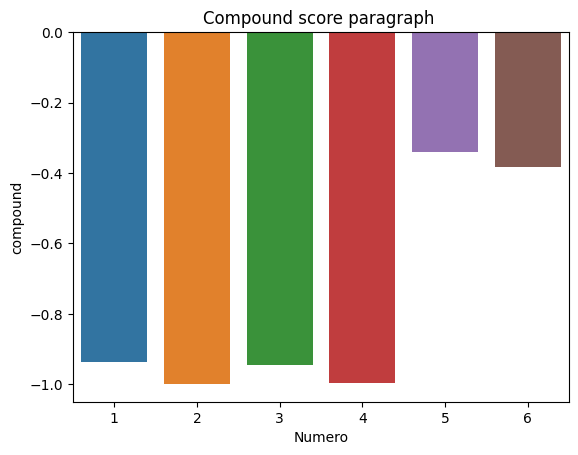

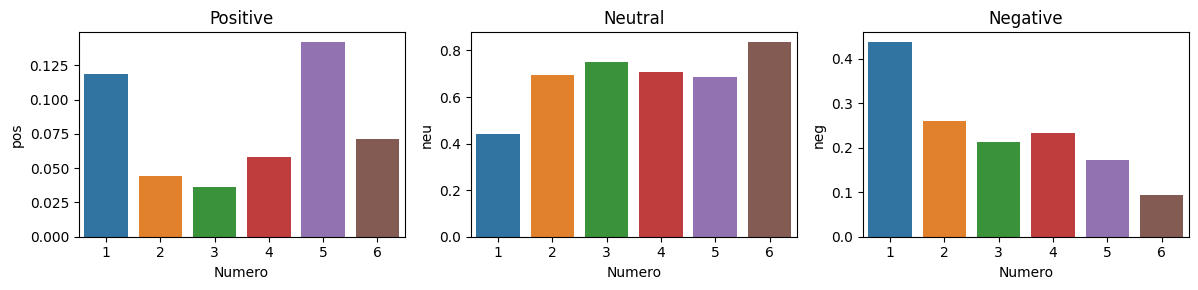

In [42]:
res_vaders_dic = vader(df_dicloreum)

In [44]:
res_vaders_dic

Numero    neg    neu    pos  compound  \
0      1  0.438  0.442  0.119   -0.9371   
1      2  0.260  0.696  0.044   -0.9997   
2      3  0.214  0.750  0.036   -0.9442   
3      4  0.234  0.708  0.058   -0.9979   
4      5  0.173  0.686  0.142   -0.3400   
5      6  0.093  0.836  0.071   -0.3818   

                                             Sezione  \
0              cos’è dicloreum dolore e a cosa serve   
1  cosa deve sapere prima di prendere dicloreum d...   
2                     come prendere dicloreum dolore   
3                     possibili effetti indesiderati   
4                   come conservare dicloreum dolore   
5    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  dicloreum dolore principio attivo diclofenac i...  
1  dicloreum dolore allergico diclofenac idrossie...  
2  medicinale seguendo esattamente riportato fogl...  
3  medicinale causare effetti indesiderati sebben...  
4  conservare temperatura inferiore  conservi med...  
5  dicloreum dolore principio attivo diclofenac i...

### UmBERTo

Some weights of the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and

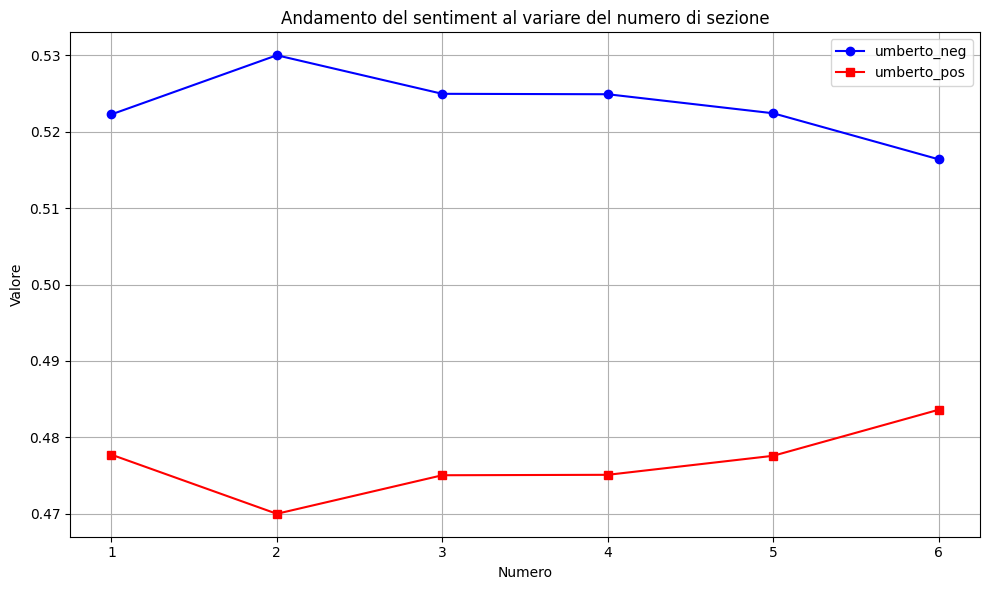

In [45]:
res_umBERTO_dic = umBERTo(df_dicloreum) 

In [46]:
res_umBERTO_dic

Numero  umberto_neg  umberto_pos  \
0      1     0.522277     0.477723   
1      2     0.530019     0.469981   
2      3     0.524971     0.475029   
3      4     0.524915     0.475085   
4      5     0.522423     0.477577   
5      6     0.516397     0.483603   

                                             Sezione  \
0              cos’è dicloreum dolore e a cosa serve   
1  cosa deve sapere prima di prendere dicloreum d...   
2                     come prendere dicloreum dolore   
3                     possibili effetti indesiderati   
4                   come conservare dicloreum dolore   
5    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  dicloreum dolore principio attivo diclofenac i...  
1  dicloreum dolore allergico diclofenac idrossie...  
2  medicinale seguendo esattamente riportato fogl...  
3  medicinale causare effetti indesiderati sebben...  
4  conservare temperatura inferiore  conservi med...  
5  dicloreum dolore principio attivo diclofenac i...

### SentITA


c:\ProgramData\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
dicloreum dolore principio attivo diclofenac idrossietilpirrolidina appartiene antiinfiammatori steroidei fans diclofenac idrossietilpirrolidina ridurre dolore infiammazione dicloreum dolore trattare dolore articolare muscolare mal schiena mal testa mal denti dolori mestruali  - opos:  9.601915e-05  - oneg:  0.0015759546
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
dicloreum dolore allergico diclofenac idrossietilpirrolidina componenti medicinale elencati  ulcera sanguinamento perforazione stomaco intestino sanguinamenti emorragia ulcera stomaco intestino ricorrenti episodi distinti emorragia stomaco intestino perforazione dovuti precedenti trattamenti fans trimestre gravidanza allattando latte materno gravidanza allattamento fertilita grave malattia fegato reni grave insufficienza epatica renale avvertenze precauzioni reazione allergica asma dolore toracico rinite eruzioni cutanee assunzione acido acetilsalicilico es aspirina dolore infiammazione appar

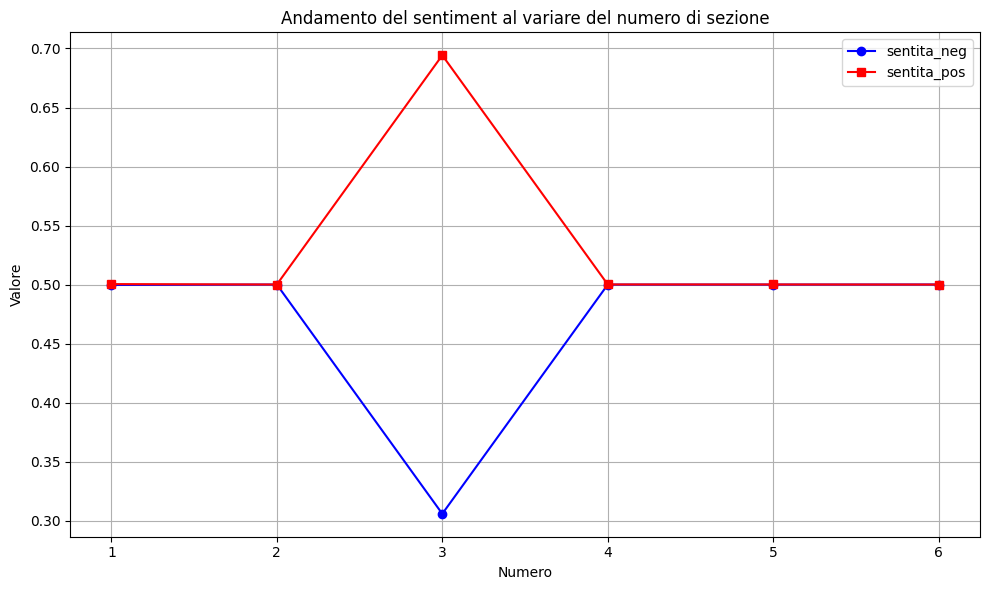

In [47]:
res_sentITA_dic= senITA(df_dicloreum)

In [48]:
res_sentITA_dic

Numero  sentita_neg  sentita_pos  \
0      1     0.499630     0.500370   
1      2     0.499986     0.500014   
2      3     0.305732     0.694268   
3      4     0.499927     0.500073   
4      5     0.499942     0.500058   
5      6     0.500012     0.499988   

                                             Sezione  \
0              cos’è dicloreum dolore e a cosa serve   
1  cosa deve sapere prima di prendere dicloreum d...   
2                     come prendere dicloreum dolore   
3                     possibili effetti indesiderati   
4                   come conservare dicloreum dolore   
5    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  dicloreum dolore principio attivo diclofenac i...  
1  dicloreum dolore allergico diclofenac idrossie...  
2  medicinale seguendo esattamente riportato fogl...  
3  medicinale causare effetti indesiderati sebben...  
4  conservare temperatura inferiore  conservi med...  
5  dicloreum dolore principio attivo diclofenac i...

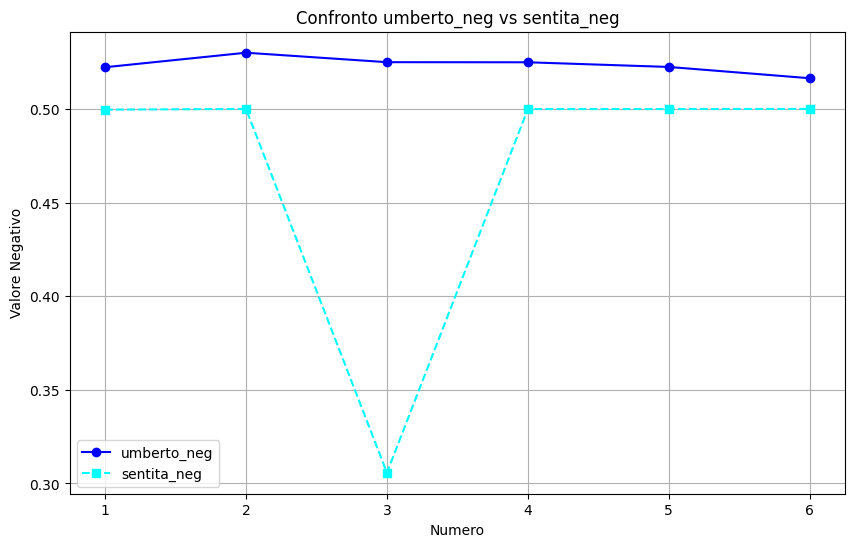

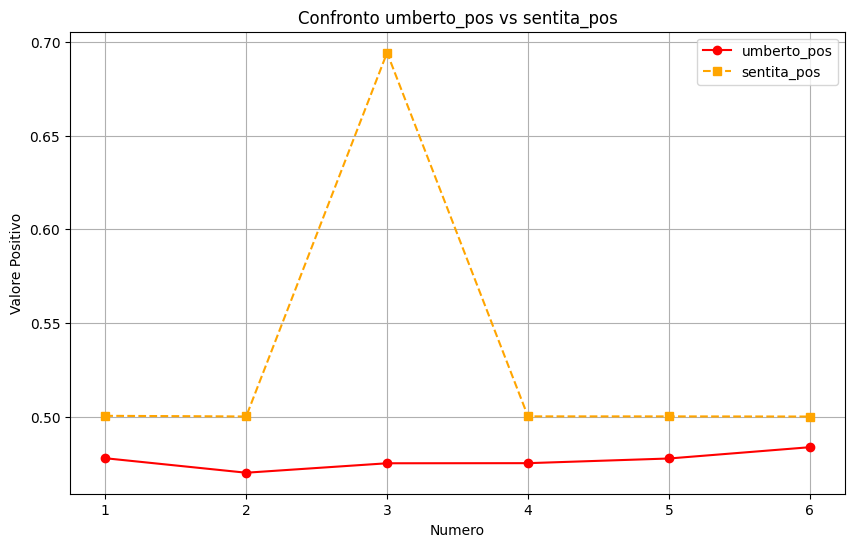

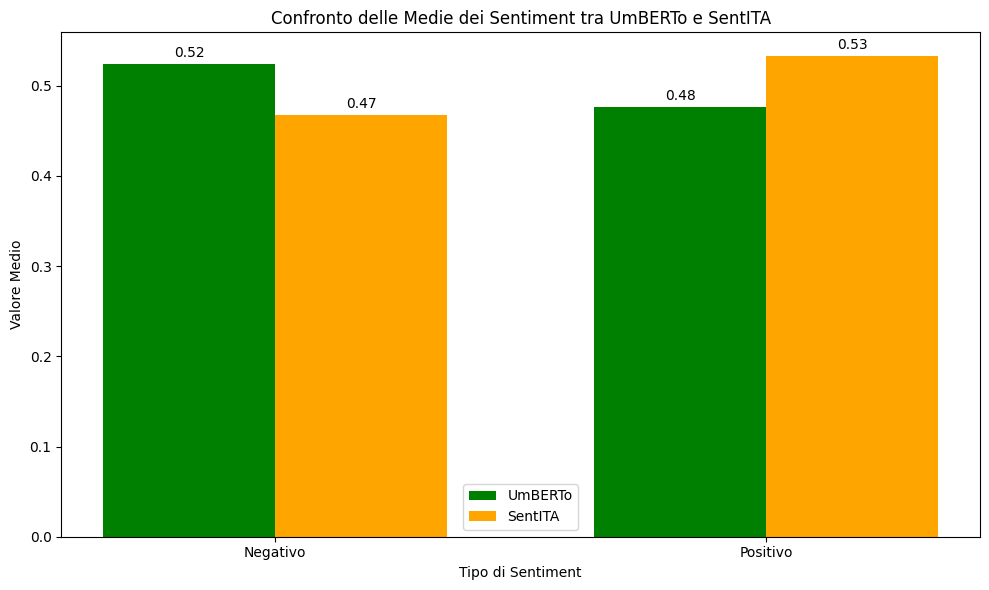

In [49]:
umBERTo_vs_sentITA(res_umBERTO_dic, res_sentITA_dic)

### FEEL-IT



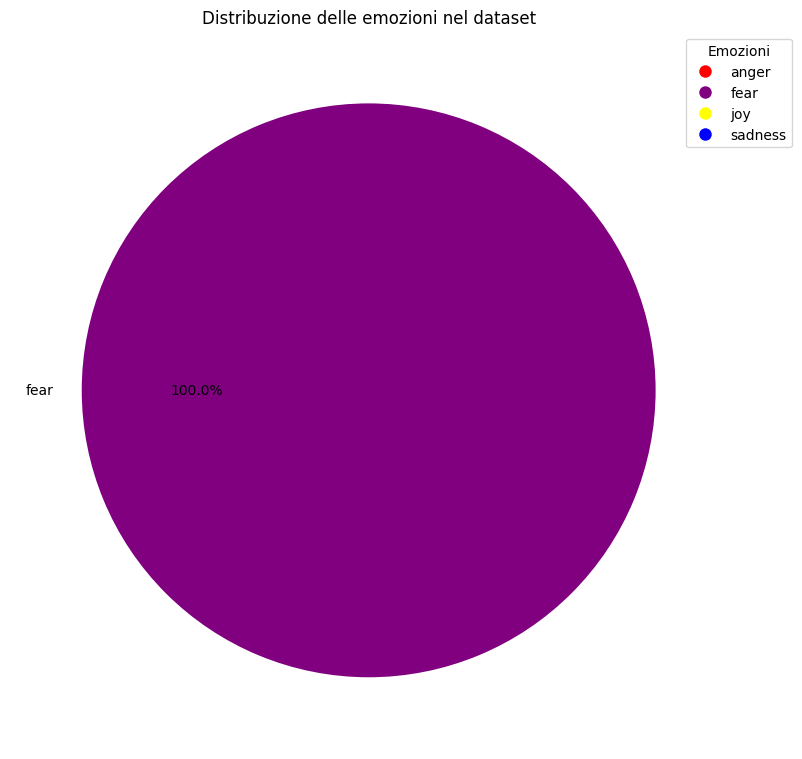

In [56]:
res_Feelit_dic= Feel_it(df_dicloreum)

In [61]:
res_Feelit_dic

Numero Emotion                                            Sezione  \
0      1    fear              cos’è dicloreum dolore e a cosa serve   
1      2    fear  cosa deve sapere prima di prendere dicloreum d...   
2      3    fear                     come prendere dicloreum dolore   
3      4    fear                     possibili effetti indesiderati   
4      5    fear                   come conservare dicloreum dolore   
5      6    fear    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  dicloreum dolore contiene principio attivo dic...  
1  dicloreum dolore allergico diclofenac idrossie...  
2  medicinale seguendo esattamente riportato fogl...  
3  medicinali medicinale causare effetti indeside...  
4  conservare temperatura inferiore  conservi med...  
5  contiene dicloreum dolore principio attivo dic...

# Fentanyl

In [27]:
#Ricavo i possibili titoli dei paragrafi
paragrafi_titoli = titoli_paragrafi('Fentanyl-hameln')

pdf_file_fen= 'fentanyl.pdf'
# Cambia l'estensione del file da 'nomefile.pdf' a 'nomefile.csv'
nome_csv_fen= pdf_file_fen.replace(".pdf", ".csv")

# Chiamare la funzione con il file PDF e i titoli dei paragrafi
df_fentanyl = estrai_paragrafi_bugiardino(pdf_file_fen, paragrafi_titoli, linea_da_escludere, is_page_number)
print(df_fentanyl)

# Salvare il DataFrame in un file CSV
df_fentanyl.to_csv(nome_csv_dicl, index=False, encoding='utf-8')

                                           Paragrafo  \
0            1. Cos’è Fentanyl-hameln e a cosa serve   
1  2. Cosa deve sapere prima di prendere Fentanyl...   
2                      3. Come usare Fentanyl-hameln   
3                  4. Possibili effetti indesiderati   
4                 5. Come conservare Fentanyl-hameln   
5  6. Contenuto della confezione e altre informaz...   

                                           Contenuto  
0  Fentanyl fa parte di un gruppo di antidolorifi...  
1  NON Le deve essere somministrato Fentanyl-hame...  
2  Fentanyl-hameln sarà iniettato in una vena da ...  
3  Come tutti i medicinali, questo medicinale può...  
4  Conservi questo medicinale fuori dalla vista e...  
5  Cosa contiene Fentanyl-hameln Il principio att...  


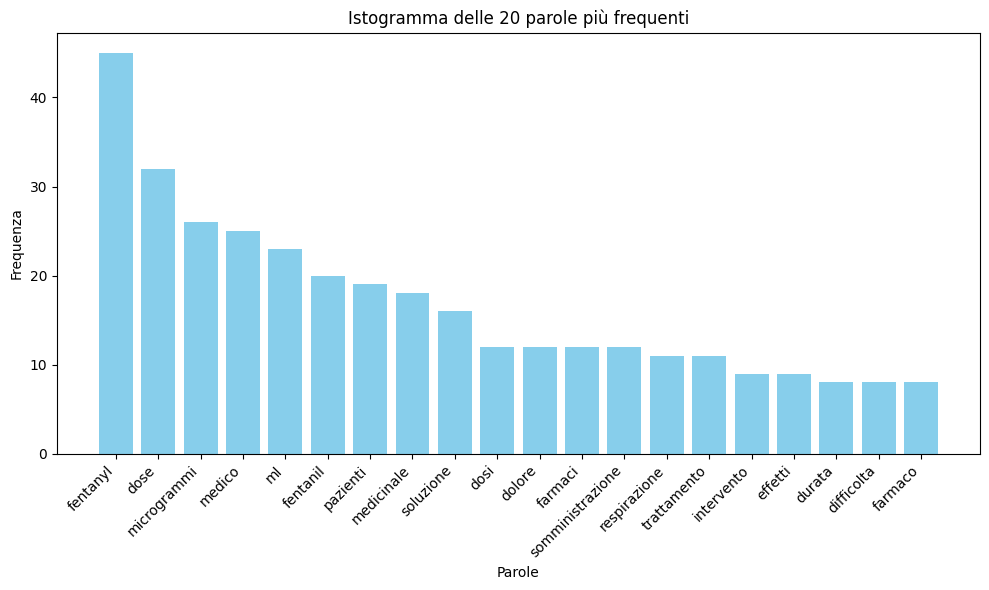

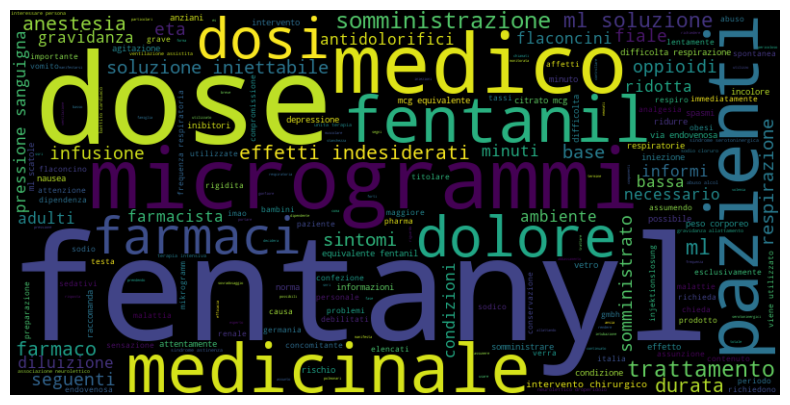

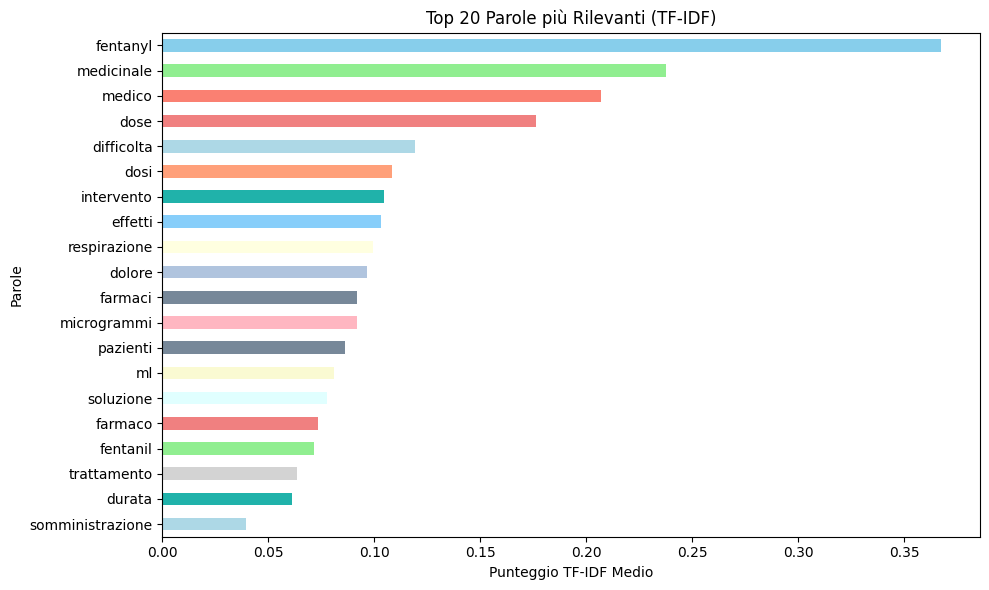

[(('ml', 'soluzione'), 9), (('effetti', 'indesiderati'), 8), (('soluzione', 'iniettabile'), 7), (('microgrammi', 'microgrammi'), 6), (('pressione', 'sanguigna'), 5), (('intervento', 'chirurgico'), 5), (('microgrammi', 'fentanil'), 5), (('informi', 'medico'), 4), (('difficolta', 'respirazione'), 4), (('medico', 'farmacista'), 4)]


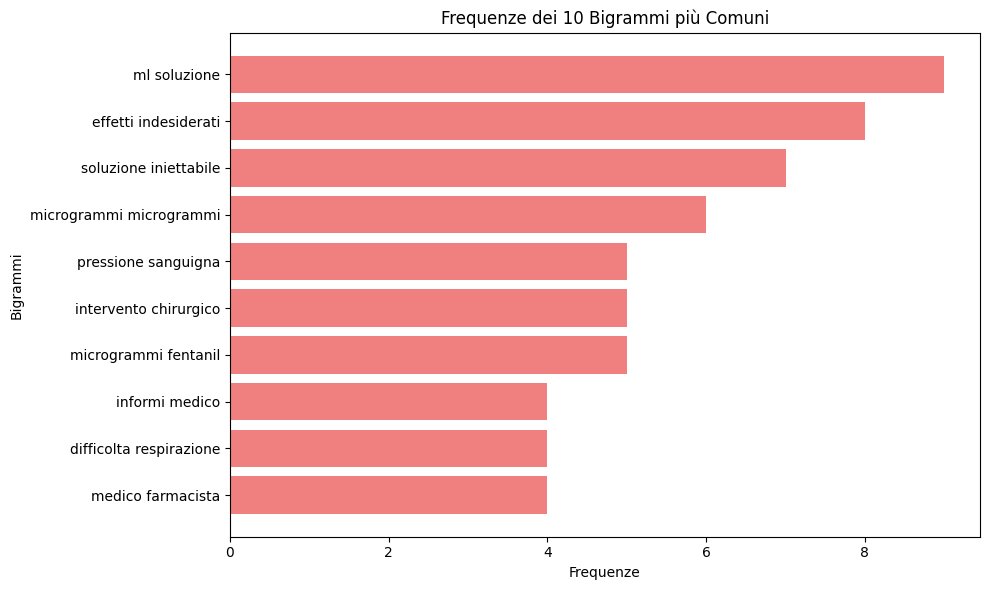

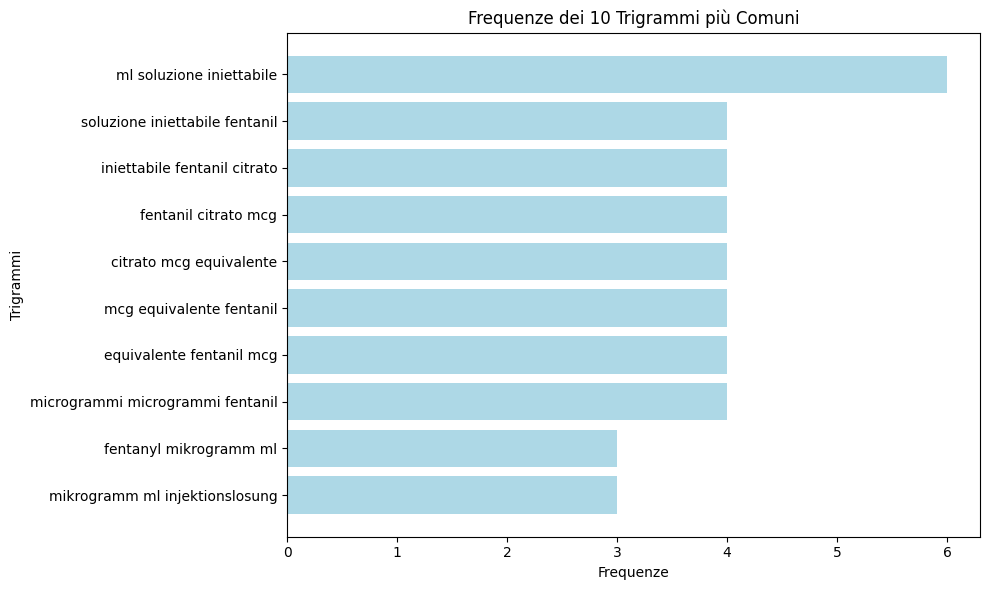

In [28]:
#fentanyl e fentanil sono la stessa cosa. In questo caso il primo riguarda il nome del prodotto che è 'Fentanyl' il secondo la sostanza
df_fentanyl= clean_stop_tok_graph(df_fentanyl, 'hameln')

In [29]:
df_fentanyl

Numero                                            Sezione  \
0      1               cos’è fentanyl-hameln e a cosa serve   
1      2  cosa deve sapere prima di prendere fentanyl-ha...   
2      3                         come usare fentanyl-hameln   
3      4                     possibili effetti indesiderati   
4      5                    come conservare fentanyl-hameln   
5      6    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  fentanyl antidolorifici forti chiamati oppioid...  
1  somministrato fentanyl  allergico fentanil sim...  
2  fentanyl  iniettato vena medico appena entri s...  
3  medicinale causare effetti indesiderati sebben...  
4  conservi medicinale vista portata bambini medi...  
5  fentanyl  principio attivo fentanil forma citr...

## Sentiment e Emotions Analysis

### Vader


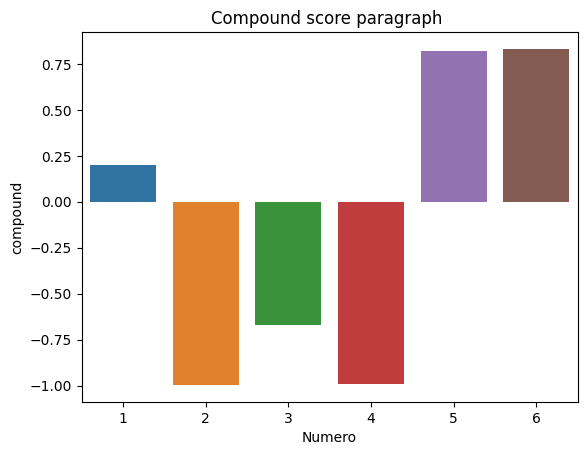

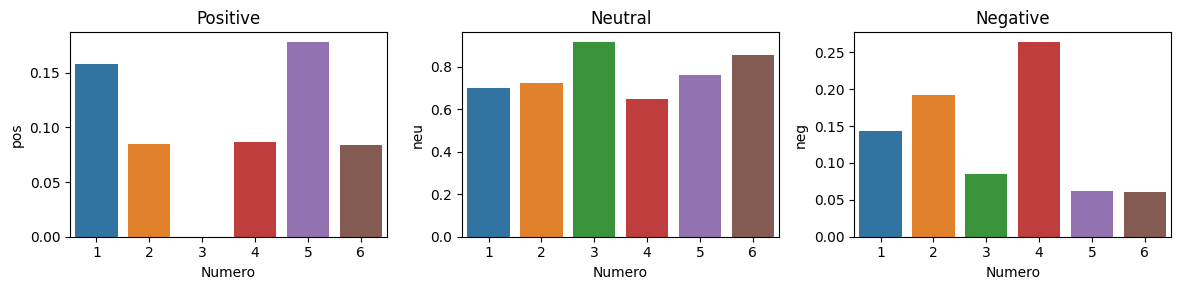

In [59]:
res_vaders_fen = vader(df_fentanyl)

In [60]:
res_vaders_fen

Numero    neg    neu    pos  compound  \
0      1  0.143  0.698  0.158    0.2023   
1      2  0.192  0.724  0.085   -0.9966   
2      3  0.085  0.915  0.000   -0.6705   
3      4  0.264  0.649  0.087   -0.9939   
4      5  0.062  0.760  0.178    0.8225   
5      6  0.061  0.855  0.084    0.8316   

                                             Sezione  \
0               cos’è fentanyl-hameln e a cosa serve   
1  cosa deve sapere prima di prendere fentanyl-ha...   
2                         come usare fentanyl-hameln   
3                     possibili effetti indesiderati   
4                    come conservare fentanyl-hameln   
5    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  fentanyl antidolorifici forti chiamati oppioid...  
1  somministrato fentanyl  allergico fentanil sim...  
2  fentanyl  iniettato vena medico appena entri s...  
3  medicinale causare effetti indesiderati sebben...  
4  conservi medicinale vista portata bambini medi...  
5  fentanyl  principio attivo fentanil forma citr...

### UmBERTo

Some weights of the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at Musixmatch/umberto-commoncrawl-cased-v1 and

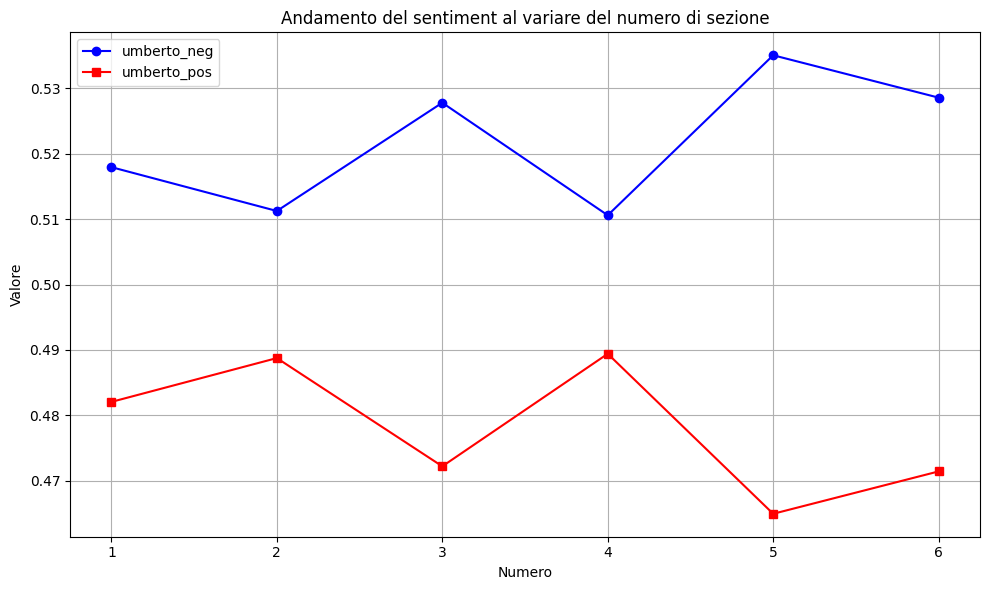

In [61]:
res_umBERTO_fen = umBERTo(df_fentanyl) 

In [71]:
res_umBERTO_fen

Numero  umberto_neg  umberto_pos  \
0      1     0.548937     0.451063   
1      2     0.541612     0.458388   
2      3     0.536561     0.463439   
3      4     0.529361     0.470639   
4      5     0.533936     0.466064   
5      6     0.520259     0.479741   

                                             Sezione  \
0               cos’è fentanyl-hameln e a cosa serve   
1  cosa deve sapere prima di prendere fentanyl-ha...   
2                         come usare fentanyl-hameln   
3                     possibili effetti indesiderati   
4                    come conservare fentanyl-hameln   
5    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  fentanyl antidolorifici forti chiamati oppioid...  
1  somministrato fentanyl  allergico fentanil med...  
2  fentanyl  iniettato vena medico appena entri s...  
3  medicinali medicinale causare effetti indeside...  
4  conservi medicinale vista portata bambini usi ...  
5  contiene fentanyl  principio attivo fentanil f...

### SentITA


c:\ProgramData\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
fentanyl antidolorifici forti chiamati oppioidi basse dosi fentanyl viene utilizzato controllare dolore interventi chirurgici breve durata garantire azione analgesica alte dosi fentanyl vengono utilizzate abbassare naturale frequenza respiratoria paziente ventilato artificialmente interventi chirurgici importanti fentanyl viene utilizzato associazione sedativo chiamato neurolettico addormentare paziente  - opos:  2.4528455e-05  - oneg:  0.00017853669
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
somministrato fentanyl  allergico fentanil simili morfina componenti medicinale elencati  reazione allergica manifestarsi forma eruzione cutanea prurito gonfiore viso labbra respiro corto malattia provoca difficolta respiratorie es asma bronchite cronica assicuri parlarne medico intervento prendendo preso antidepressivo famiglia inibitori monoaminossidasi imaos fentanyl  riguardo sindrome serotoninergica fentanil imao farmaci serotoninergici ssri snri aumento pre

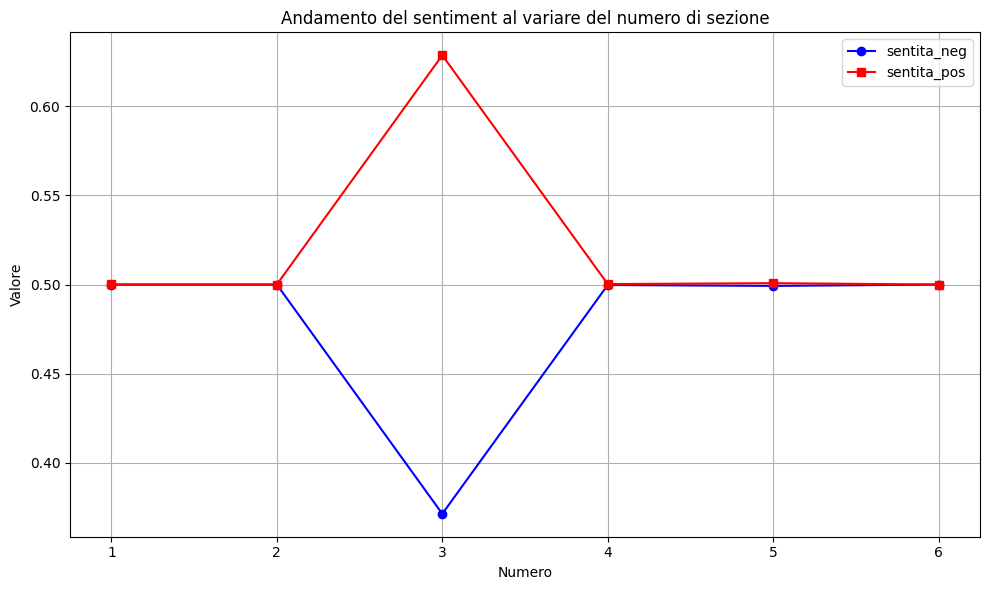

In [62]:
res_sentITA_fen= senITA(df_fentanyl)

In [63]:
res_sentITA_fen

Numero  sentita_neg  sentita_pos  \
0      1     0.499962     0.500039   
1      2     0.499988     0.500012   
2      3     0.371288     0.628712   
3      4     0.499745     0.500255   
4      5     0.499228     0.500772   
5      6     0.499997     0.500003   

                                             Sezione  \
0               cos’è fentanyl-hameln e a cosa serve   
1  cosa deve sapere prima di prendere fentanyl-ha...   
2                         come usare fentanyl-hameln   
3                     possibili effetti indesiderati   
4                    come conservare fentanyl-hameln   
5    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  fentanyl antidolorifici forti chiamati oppioid...  
1  somministrato fentanyl  allergico fentanil sim...  
2  fentanyl  iniettato vena medico appena entri s...  
3  medicinale causare effetti indesiderati sebben...  
4  conservi medicinale vista portata bambini medi...  
5  fentanyl  principio attivo fentanil forma citr...

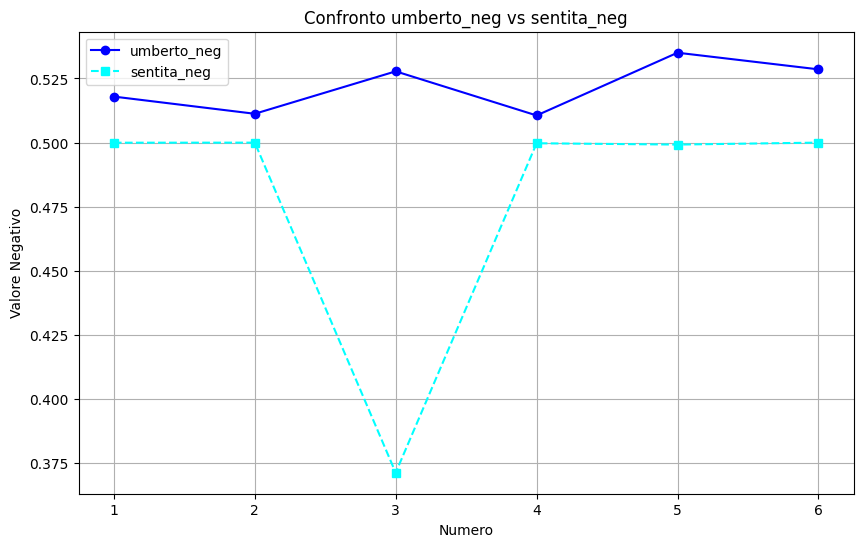

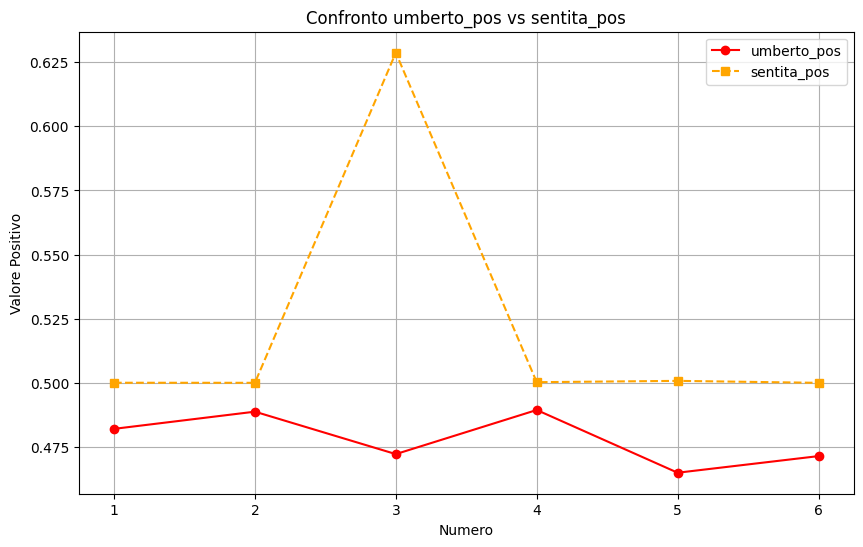

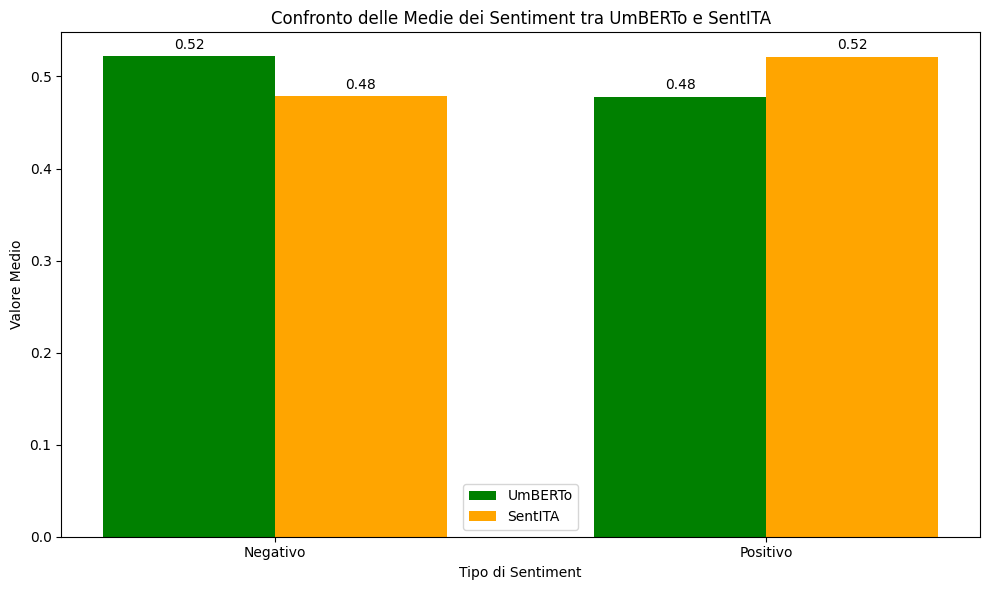

In [64]:
umBERTo_vs_sentITA(res_umBERTO_fen, res_sentITA_fen)

### FEEL-IT



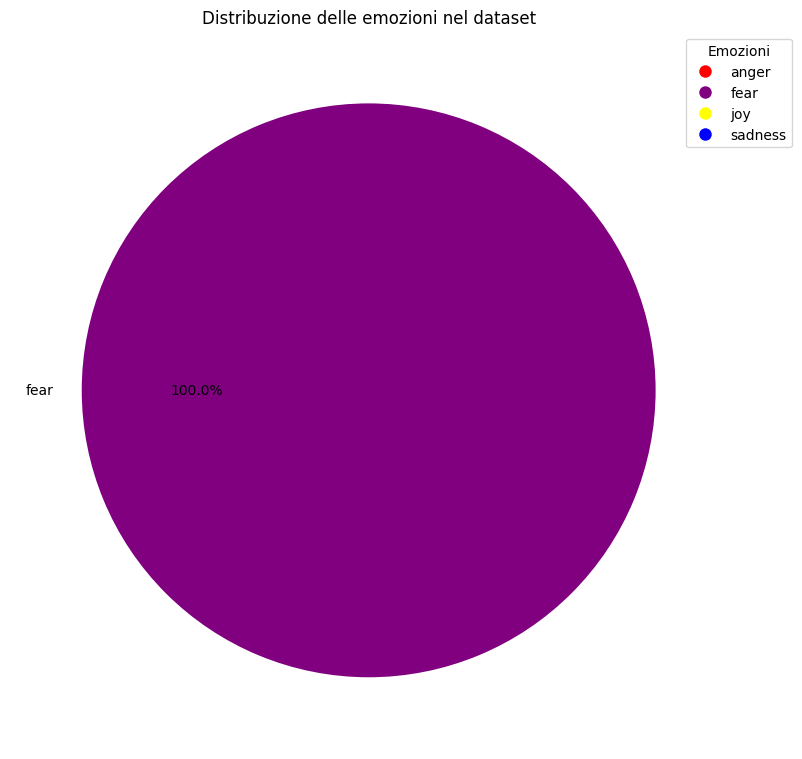

In [65]:
res_Feelit_fen= Feel_it(df_fentanyl)

In [76]:
res_Feelit_fen

Numero Emotion                                            Sezione  \
0      1    fear               cos’è fentanyl-hameln e a cosa serve   
1      2    fear  cosa deve sapere prima di prendere fentanyl-ha...   
2      3    fear                         come usare fentanyl-hameln   
3      4    fear                     possibili effetti indesiderati   
4      5    fear                    come conservare fentanyl-hameln   
5      6    fear    contenuto della confezione e altre informazioni   

                                           Contenuto  
0  fentanyl antidolorifici forti chiamati oppioid...  
1  somministrato fentanyl  allergico fentanil med...  
2  fentanyl  iniettato vena medico appena entri s...  
3  medicinali medicinale causare effetti indeside...  
4  conservi medicinale vista portata bambini usi ...  
5  contiene fentanyl  principio attivo fentanil f...

# Topic modeling

In [31]:
# Unire le righe della colonna 'Contenuto' per ogni dataset
morfina_content = ' '.join(df_morfina['Contenuto'].tolist())
bisolvon_content = ' '.join(df_bisolvon['Contenuto'].tolist())
borocillina_content = ' '.join(df_borocillina['Contenuto'].tolist())
dicloreum_content = ' '.join(df_dicloreum['Contenuto'].tolist())
fentanyl_content = ' '.join(df_fentanyl['Contenuto'].tolist())

In [32]:
morfina_content

'morfina cloridrato principio attivo morfina cloridrato appartenente detti analgesici oppioidi derivanti lavorazione oppio agiscono diminuendo dolore livello cerebrale medicinale indicato trattamento dolore moderato grave trattamenti antidolorifici efficaci dovuto tumori neoplasie dovuto problemi cuore infarto miocardio interventi chirurgia dovuto problemi polmoni edema polmonare acuto morfina indicata indurre anestesia parto parto analgesia epidurale interventi chirurgici anestetico loco regionale morfina cloridrato allergico morfina cloridrato simili classe morfina cloridrato componenti medicinale elencati  allergico manifestare rossore viso prurito difficolta respirare restringimento bronchi broncospasmo reazioni allergiche gravi reazioni anafilattiche problemi stomaco intestino addome acuto ileo paralitico difficolta respirare depressione respiratoria gravi problemi fegato insufficienza epatocellulare grave problemi cuore associati disturbi respirazione scompenso cardiaco secondari

In [33]:
farmaci = [
   'morfina',
   'bisolvon',
   'borocillina',
   'dicloreum',
   'fentanyl'
]

for i in range(0,5) : 
    print ('farmaco:  ',farmaci[i])

farmaco:   morfina
farmaco:   bisolvon
farmaco:   borocillina
farmaco:   dicloreum
farmaco:   fentanyl


In [34]:
# Creare una lista contenente il contenuto di ogni dataset
contents = [morfina_content, bisolvon_content, borocillina_content, dicloreum_content, fentanyl_content]


In [35]:
contents

['morfina cloridrato principio attivo morfina cloridrato appartenente detti analgesici oppioidi derivanti lavorazione oppio agiscono diminuendo dolore livello cerebrale medicinale indicato trattamento dolore moderato grave trattamenti antidolorifici efficaci dovuto tumori neoplasie dovuto problemi cuore infarto miocardio interventi chirurgia dovuto problemi polmoni edema polmonare acuto morfina indicata indurre anestesia parto parto analgesia epidurale interventi chirurgici anestetico loco regionale morfina cloridrato allergico morfina cloridrato simili classe morfina cloridrato componenti medicinale elencati  allergico manifestare rossore viso prurito difficolta respirare restringimento bronchi broncospasmo reazioni allergiche gravi reazioni anafilattiche problemi stomaco intestino addome acuto ileo paralitico difficolta respirare depressione respiratoria gravi problemi fegato insufficienza epatocellulare grave problemi cuore associati disturbi respirazione scompenso cardiaco secondar

In [36]:
#Tokenizzazione contenuto di ogni paragrafo per i 5 bugiardini
content_tokenizzati = []

for content in contents:
    tokens = word_tokenize(content)
    content_tokenizzati.append(tokens)

print("Esempio di token del primo farmaco:")
print(content_tokenizzati[0][250:260])

Esempio di token del primo farmaco:
['coscienza', 'shock', 'problemi', 'digestione', 'rallentamento', 'blocco', 'gastrointestinale', 'disturbi', 'intestinali', 'dovuti']


### Topic
Sono stati selezionati 5 topic


In [37]:
# Creazione del dizionario e del corpus per LDA
dictionary = corpora.Dictionary(content_tokenizzati)
corpus_bow = [dictionary.doc2bow(cont) for cont in content_tokenizzati]

# Definizione del numero di topic
num_topics = 5


In [38]:
corpus_bow

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 3),
  (6, 1),
  (7, 1),
  (8, 5),
  (9, 2),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 2),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 2),
  (22, 2),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 8),
  (29, 1),
  (30, 1),
  (31, 5),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 2),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 4),
  (41, 5),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 3),
  (50, 2),
  (51, 1),
  (52, 3),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 3),
  (57, 1),
  (58, 1),
  (59, 2),
  (60, 4),
  (61, 5),
  (62, 5),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 2),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 2),
  (72, 1),
  (73, 2),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 2),
  (81, 4),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 3),
  (86, 1),
  (87, 2),
  (88, 3),
  (89, 1),
  (90, 10),
  (91, 2

In [39]:
for i in range(len(content_tokenizzati)):
    print(f"Numero di token nel farmaco {farmaci[i]}: {len(content_tokenizzati[i])}")

Numero di token nel farmaco morfina: 1952
Numero di token nel farmaco bisolvon: 612
Numero di token nel farmaco borocillina: 2264
Numero di token nel farmaco dicloreum: 1432
Numero di token nel farmaco fentanyl: 1770


In [40]:
# Creazione del modello LDA
lda_model = LdaModel(corpus_bow, num_topics=num_topics, id2word=dictionary, passes=15)

In [41]:
# Ottenere le parole chiave e i loro pesi per ciascun topic
topics = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)

In [48]:
topics

[(1, 0.999543)]

In [42]:
# Creare un dataset per ogni topic
topic_datasets = []
for topic_id, topic in topics:
    words = [word for word, _ in topic]
    weights = [weight for _, weight in topic]
    topic_df = pd.DataFrame({'Parola': words, 'Peso': weights})
    topic_datasets.append(topic_df)

# Visualizzare i dataset per ogni topic
for idx, topic_df in enumerate(topic_datasets):
    print(f"Topic {idx + 1}:")
    print(topic_df)
    print("\n")

Topic 1:
          Parola      Peso
0     medicinale  0.000571
1         dolore  0.000556
2         medico  0.000546
3    trattamento  0.000540
4  infiammazione  0.000532
5        morfina  0.000519
6        sintomi  0.000517
7        effetti  0.000517
8    borocillina  0.000515
9           dose  0.000515


Topic 2:
        Parola      Peso
0     fentanyl  0.020571
1         dose  0.014664
2  microgrammi  0.011925
3       medico  0.011481
4           ml  0.010558
5     fentanil  0.009194
6     pazienti  0.008740
7   medicinale  0.008292
8    soluzione  0.007375
9       dolore  0.005561


Topic 3:
        Parola      Peso
0      morfina  0.020737
1       medico  0.014663
2         dose  0.014515
3   medicinale  0.012825
4   cloridrato  0.012759
5       dolore  0.012383
6  trattamento  0.012301
7     problemi  0.011089
8    dicloreum  0.010392
9           mg  0.009293


Topic 4:
          Parola      Peso
0         dolore  0.024557
1  infiammazione  0.022282
2    borocillina  0.016104
3  

In [43]:
# Distribuzione dei topic per farmaco

for i, doc in enumerate(corpus_bow):
    print(f'Farmaco {farmaci[i]}:')
    topics = lda_model.get_document_topics(doc)
    print("Distribuzione dei topic: Topic", (topics[0][0] +1), "con probabilità", round(topics[0][1],4))
    print('\n')

Farmaco morfina:
Distribuzione dei topic: Topic 3 con probabilità 0.9996


Farmaco bisolvon:
Distribuzione dei topic: Topic 5 con probabilità 0.9987


Farmaco borocillina:
Distribuzione dei topic: Topic 4 con probabilità 0.9996


Farmaco dicloreum:
Distribuzione dei topic: Topic 3 con probabilità 0.5822


Farmaco fentanyl:
Distribuzione dei topic: Topic 2 con probabilità 0.9995




In [47]:
topics

[(1, 0.999543)]

In [45]:
# Misuro la coerenza dei topic con il metodo UMass
coherence_umass = CoherenceModel(model=lda_model, corpus=corpus_bow, dictionary=dictionary, coherence='u_mass')
umass_scores = coherence_umass.get_coherence_per_topic()

# Creazione di un DataFrame per i punteggi di coerenza UMass
df_umass = pd.DataFrame({'Topic': range(1,len(umass_scores)+1), 'Coerenza UMass': umass_scores})
df_umass['Coerenza UMass'] = df_umass['Coerenza UMass'].round(2)

display(df_umass)

Topic  Coerenza UMass
0      1           -0.65
1      2           -0.13
2      3           -0.75
3      4           -0.22
4      5           -0.28

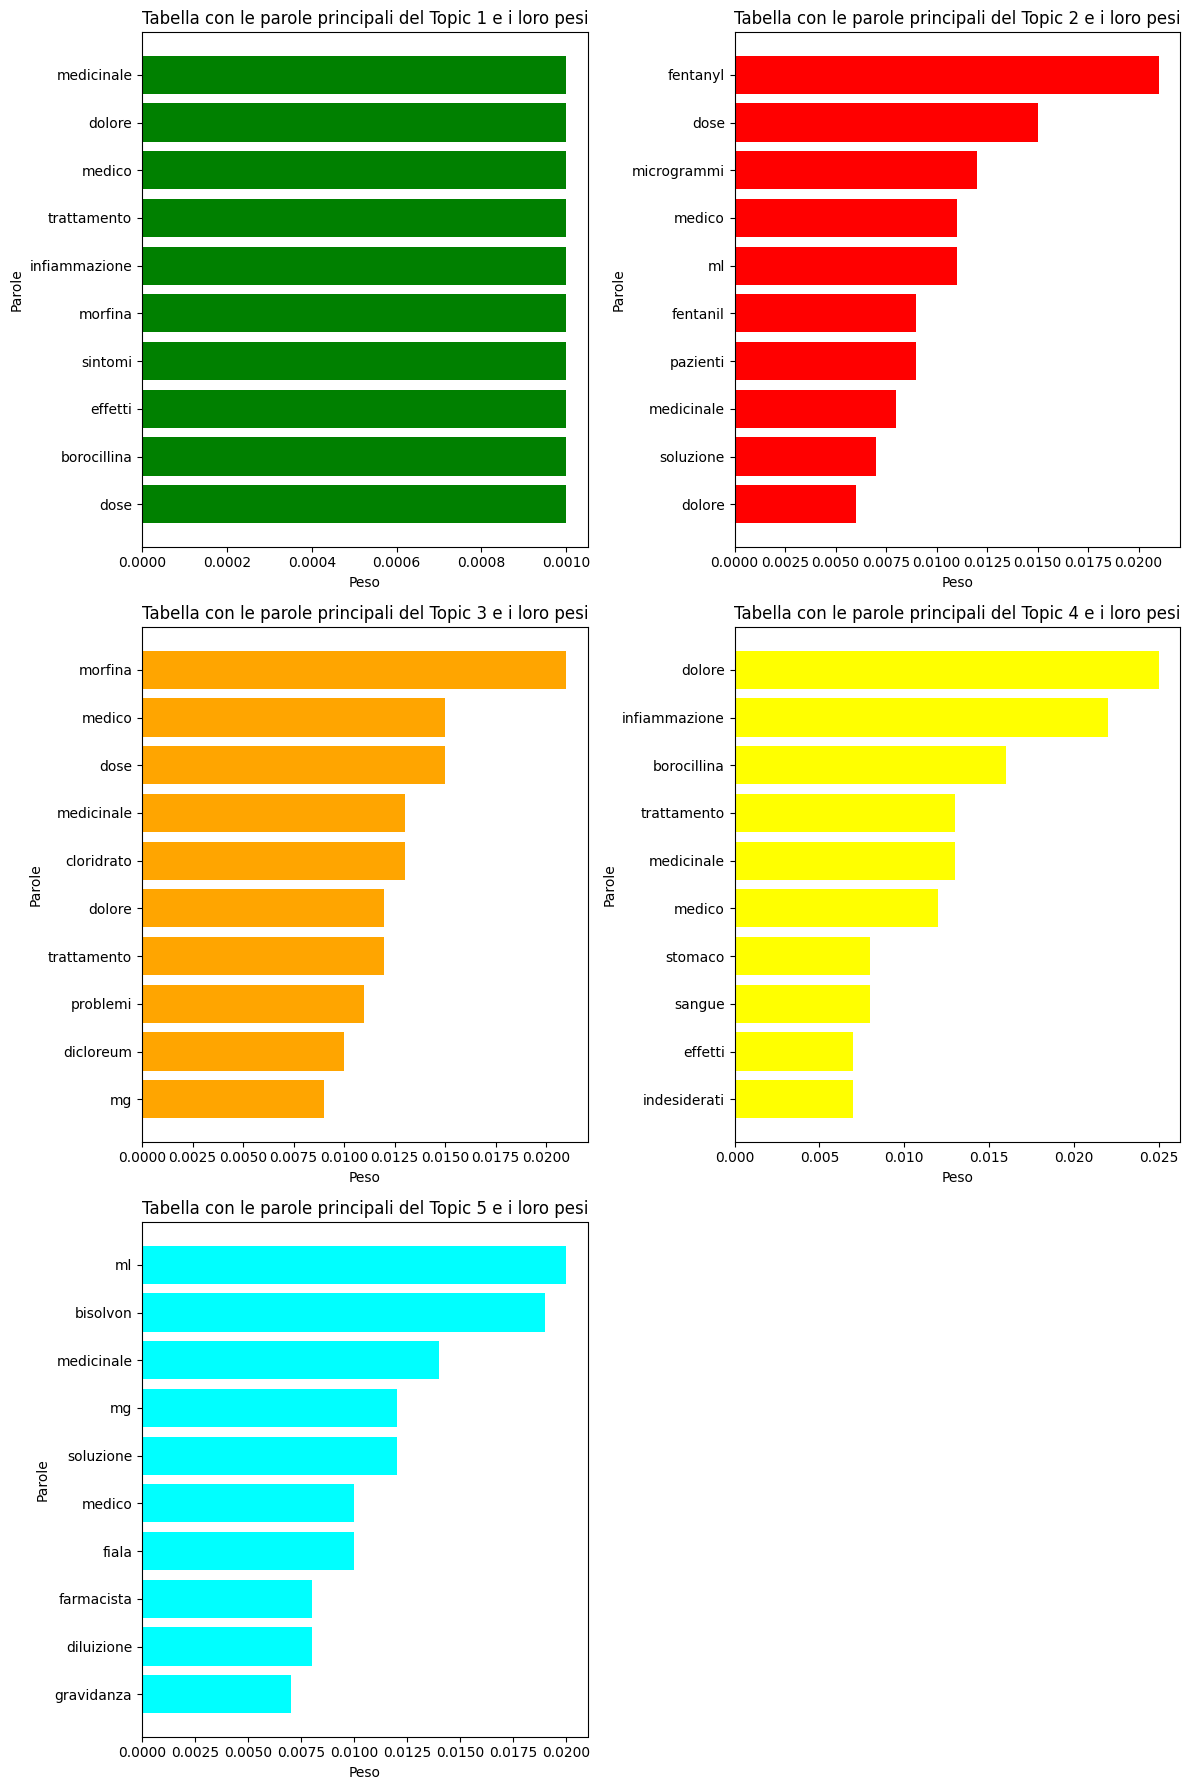

In [61]:
# Istogrammi delle parole e dei loro pesi per ogni topic

colori = [ 'green', 'red', 'orange', 'yellow', 'cyan']

# Lista dei topic
topics2 = lda_model.print_topics()


# Estrai le parole e le relative frequenze per ogni topic
topic_words = {}
for idx, topic in enumerate(topics2):
    topic_id, word_dist = topic
    word_dist = word_dist.split("+")
    words = [wd.split("*")[1].strip().strip('"') for wd in word_dist]
    freqs = [float(wd.split("*")[0]) for wd in word_dist]
    topic_words[topic_id] = {"parole": words[::-1], "frequenze": freqs[::-1], "colore": colori[idx % len(colori)]}

# Numero di righe e colonne dei subplot
num_rows = len(topic_words) // 2 + len(topic_words) % 2
num_cols = 2

# Disegna gli istogrammi per ogni topic
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6*num_rows))

for i, (topic_id, words_freqs) in enumerate(topic_words.items()):
    row = i // num_cols
    col = i % num_cols

    df = pd.DataFrame(words_freqs)
    ax = axes[row, col] if num_rows > 1 else axes[col]

    ax.barh(df["parole"], df["frequenze"], color=words_freqs["colore"])  # Utilizzo di plt.barh
    ax.set_xlabel('Peso')  # Etichetta asse x
    ax.set_ylabel('Parole')  # Etichetta asse y
    ax.set_title(f'Tabella con le parole principali del Topic {topic_id+1} e i loro pesi')
    ax.tick_params(axis='y', rotation=0)  # Ruota le etichette sull'asse y

# Rimuovi eventuali subplot vuoti
if len(topic_words) % 2 != 0:
    fig.delaxes(axes[num_rows-1, 1])

plt.tight_layout()
plt.show()
